In [1]:
%matplotlib inline

import load_local_neo_odml_elephant
import os

import numpy as np
from autograd import grad, jacobian
import numdifftools as nd

import random
import math
import time
import seaborn as sns
from scipy import signal
from scipy import stats
from scipy import optimize
from scipy.fft import rfft, rfftfreq, ifft
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import gridspec, ticker, colors
from matplotlib.pyplot import rcParams
from mpl_toolkits import mplot3d
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML

from reachgraspio import reachgraspio
import odml.tools
import neo_utils
import odml_utils
import quantities as pq

from elephant.signal_processing import butter
from neo import Block, Segment


rcParams.update({'font.size': 13})
rcParams['figure.autolayout'] = True
rcParams['legend.fontsize'] = 15
rcParams['axes.labelsize'] = 15
rcParams['axes.titlepad'] = 10
rcParams['axes.labelpad'] = 20
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['mathtext.fontset'] = 'cm'  
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Verdana']  
rcParams['animation.ffmpeg_path'] = r'/Users/administrator/Desktop/ffmpeg'

elephant/elephant/spade.py:80: UserWarning: fim.so not found in elephant/spade_src folder,you are using the python implementation of fast fca
  warnings.warn(


In [48]:
# Functions

def get_monkey_datafile(monkey):
    if monkey == "Lilou":
        return "l101210-001"  # ns2 and ns5 present
    elif monkey == "Nikos2":
        return "i140703-001"  # ns2 and ns6 present
    else:
        return ""

def autocorr(x,lags): 
    """
    Autocorrelation function for data and network response 
    """
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    return np.array(corr)
    
def nonlinearity(x, theta=0, phi_max=1):
    """
    Network nonlinearity (positive sigmoid)
    """
    return phi_max / (1 + np.exp(-(x-theta)))

def get_noise(N, n_trials, tau_wn, amp_wn, mean_wn):
    """
    Define Ornstein-Uhlenbeck noise input 
    """
    noises = []
    for trial in range(n_trials):  
        noise = np.zeros((N, iterations))
        for i in range(iterations-1):
            noise[:, i+1] = noise[:, i] + ((mean_wn - noise[:, i]) / tau_wn) + amp_wn * np.sqrt(2*dt/tau) * np.random.randn(N)
        noises.append(noise)
    return noises 

def tau_to_ms(tau):
    """
    Conversion factor from network timescale to ms
    """
    return tau * ((rescale_ms[-1].magnitude / max_length))

def ms_to_tau(ms):
    """
    Conversion factor from ms to network timescale
    """
    return ms /  ((rescale_ms[-1].magnitude / max_length))

def eigval_to_hz(eigval):
    """
    Conversion factor from eigenvalues of Jacobian to Hz
    """
    return eigval / ((rescale_ms[-1].magnitude / max_length) / 1000) / (np.pi * 2) 

def hz_to_eigval(hz):
    """
    Conversion factor from Hz to eigenvalues of Jacobian
    """
    return hz * ((rescale_ms[-1].magnitude / max_length) / 1000) * (np.pi * 2) 


# Functions for weight decay analysis 

def get_circular_indices(centre, radius):
    """
    Get indices of units a specified radius away from specified centre on electrode grid 
    """
    y, x = np.ogrid[:10, :10]
    dist_from_centre = np.sqrt((x - centre[1])**2 + (y-centre[0])**2)
    indices = dist_from_centre == radius
    values = reshape[indices]
    return values

def weights_vs_distance(J, distances):
    """
    Define mean weight between units separated by specific distance
    """
    dist_means = []
    dist_stds = []
    for dist in distances:
        dists_store = []
        for row in range(10):
            for col in range(10):
                values = get_circular_indices(centre=[row, col], radius=dist)
                for val in values:
                    if reshape[row][col] != -2 and val != -2:
                        dists_store.append(J[reshape[row][col], val])     
        dist_means.append(np.mean(dists_store))
        dist_stds.append(np.std(dists_store))
    return dist_means, dist_stds

def weights_vs_distance_pos_neg(J, distances):
    """
    Define mean weight between units separated by specific distance, separated into positive and negative weights
    """
    pos_means = []
    pos_stds = []
    neg_means = []
    neg_stds = []
    for dist in distances:
        pos_store = []
        neg_store = []
        for row in range(10):
            for col in range(10):
                values = get_circular_indices(centre=[row, col], radius=dist)
                for val in values:
                    if reshape[row][col] != -2 and val != -2:
                        if J[reshape[row][col], val] > 0:
                            pos_store.append(J[reshape[row][col], val]) 
                        if J[reshape[row][col], val] < 0:
                            neg_store.append(J[reshape[row][col], val]) 
        pos_means.append(np.mean(pos_store))
        pos_stds.append(np.std(pos_store))
        neg_means.append(np.mean(neg_store))
        neg_stds.append(np.std(neg_store))
    return pos_means, pos_stds, neg_means, neg_stds

def training(D, dt_weight_update, n_train, tau_trial, tau_baseline, amp_trial, amp_baseline):
    """
    Train network with given input noise parameters; return initial and trained connectivity matrix 
    """
    n_tot = n_train + 1
    
    noise_trial = get_noise(N, 1, tau_trial, amp_trial, 0.0) 
    noise_baseline = get_noise(N, 1, tau_baseline, amp_baseline, 0.0)

    P = np.eye(n_targets) / alpha 
    J0 = np.random.randn(N, N) * g / np.sqrt(N) 
    J = J0.copy()

    for run in range(n_tot):
        xs = np.zeros((N, iterations))  
        zs = np.zeros((N, iterations)) 
        if run>0:
            xs[:, 0] = last_run

        for t in range(D, iterations-1):
            xs[:, t+1] = xs[:, t] + (-xs[:, t] + J.dot(nonlinearity(xs[:, t-D])) + noise_trial[0][:, t] + noise_baseline[0][:, t]) * dt / tau
            r = nonlinearity(xs[:, t+1]) 
            r = r[:, None]    
            zs[:, t+1] = J.dot(np.squeeze(r))
            
            if run < n_train and t % dt_weight_update == 0:
                errs = zs[:n_targets, t+1] - targets[0][:, t+1]
                k = P.dot(r[:n_targets])
                rPr = r[:n_targets].T.dot(k)
                c = 1.0 / (1.0 + rPr)
                P = P - c * (k.dot(k.T))
                delta_w = - (c * np.outer(errs, k))
                J[:n_targets, :n_targets] += delta_w
                J[np.isclose(J, 0.0, atol=1e-04)] = 0.0

        last_run = xs[:, -1]
        
    return J0, J

    
# General parameters

amplitude_unit = pq.microvolt
time_unit = pq.ms
Writer = animation.writers['ffmpeg']
writer = Writer(fps=50, bitrate=1800)

main_color = 'darkcyan'
main_color_dark = 'darkslategrey'
positive_color = 'darkgreen'
negative_color = 'darkred'



### Load session and split into trials

In [3]:
# Specify directory where the data is stored
datasetdir = "/Users/administrator/multielectrode_grasp/datasets/"

# Specify which monkey to analyse
monkey = 'Lilou'

nsx_none = {'Lilou': None, 'Nikos2': None}
nsx_lfp = {'Lilou': 2, 'Nikos2': 2}
nsx_raw = {'Lilou': 5, 'Nikos2': 6}

datafile = get_monkey_datafile(monkey)

# Open the session for reading
session = reachgraspio.ReachGraspIO(filename=os.path.join(datasetdir, datafile), odml_directory=datasetdir)

# Read the first 50s of data from chosen number of electrodes

chosen_els = range(100)
chosen_units = 1

bl_raw = session.read_block(
    nsx_to_load=nsx_raw[monkey],
    n_starts=None,
    n_stops=50 * pq.s,
    channels=chosen_els,
    units=chosen_units,
    load_waveforms=False,
    load_events=True,
    scaling='voltage',
    lazy=False,
    cascade=True,
    correct_filter_shifts=True)

# Access the single segment of the data block, containing all trials 
assert len(bl_raw.segments) == 1
seg_raw = bl_raw.segments[0]  # there is only 1 segment 


warning[None:17:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag (line 17)
warning[None:17:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML> (line 17)


In [10]:
# Get start and stop events of trials with correct performance
start_events = neo_utils.get_events(
    seg_raw,
    properties={
        'name': 'TrialEvents',
        'trial_event_labels': 'CUE-OFF',
        'performance_in_trial': 255})
stop_events = neo_utils.get_events(
    seg_raw,
    properties={
        'name': 'TrialEvents',
        'trial_event_labels': 'GO-ON',
        'performance_in_trial': 255})

assert len(start_events) == 1
assert len(stop_events) == 1

# Create epochs around start and stop events 
epoch = neo_utils.add_epoch(
    seg_raw,
    start_events[0],
    stop_events[0],
    pre = +50 * pq.ms,
    post = -250 * pq.ms,
    trial_status='complete_trials',
    trial_type=start_events[0].annotations['belongs_to_trialtype'],
    trial_performance=start_events[0].annotations['performance_in_trial'])

raw_block = Block(name='raw_analysis_epoch')
raw_block.segments = neo_utils.cut_segment_by_epoch(seg_raw, epoch, reset_time=True)  # each segment = 1 trial


### Create targets from filtered LFP signals

96
96
96
96
96


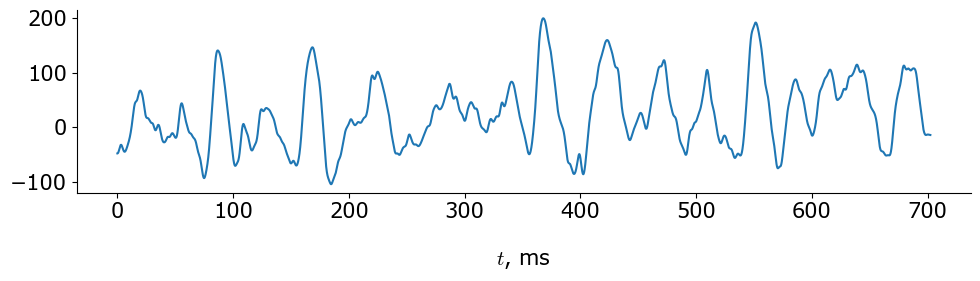

In [11]:
# Choose trials

trial_ids = [2, 3, 6, 7, 8]
n_signals = len(raw_block.segments[0].analogsignals)

# Apply bandpass filter
filtered_signals = [] 
for trial in trial_ids:
    filtered_anasig = []
    print(len(raw_block.segments[trial].analogsignals))
    for anasig in raw_block.segments[trial].analogsignals:
        f_anasig = butter(
                anasig,
                highpass_freq=None,
                lowpass_freq=250 * pq.Hz,
                order=4)
        f_anasig.name = 'offline_lfp_%s' % anasig.name 
        filtered_anasig.append(f_anasig)

    # Attach all offline filtered LFPs to the raw_block segment of each trial 
    raw_block.segments[trial].analogsignals.extend(filtered_anasig)

    # Separate raw and filtered signals 
    raw_sigs = raw_block.segments[trial].analogsignals[0:n_signals]
    filtered_sigs = raw_block.segments[trial].analogsignals[n_signals:]
    filtered_signals.append(filtered_sigs)
    
# Find signal with shortest length
shortest = np.argmin([len(x[0]) for x in filtered_signals])
rescale_ms = filtered_signals[shortest][0].times.rescale(pq.ms)
max_length = min([len(x[0]) for x in filtered_signals])
    
# Plot to check 
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
ax.plot(rescale_ms, filtered_signals[0][0].squeeze().rescale(pq.microvolt)[:max_length])
ax.set_xlabel(r'$t$, ms')
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()
plt.show()


In [12]:
# Create targets from filtered signals

targets = []
for filtered_sig in filtered_signals:
    targets_unselected = []
    for sig in filtered_sig:
            targets_unselected.append(sig.squeeze().rescale(amplitude_unit))

    remove_idxs = [42] 
    for idx, timeseries in enumerate(targets_unselected):
        if np.max(np.abs(timeseries)) > 250:
            remove_idxs.append(idx)

    targets_unselected = [x.magnitude for x in targets_unselected]
    targets_trial = np.vstack(targets_unselected)

    for bad in remove_idxs:
        targets_trial[bad] = 0.0

    targets_trial = targets_trial/targets_trial.max()
    targets.append(targets_trial)


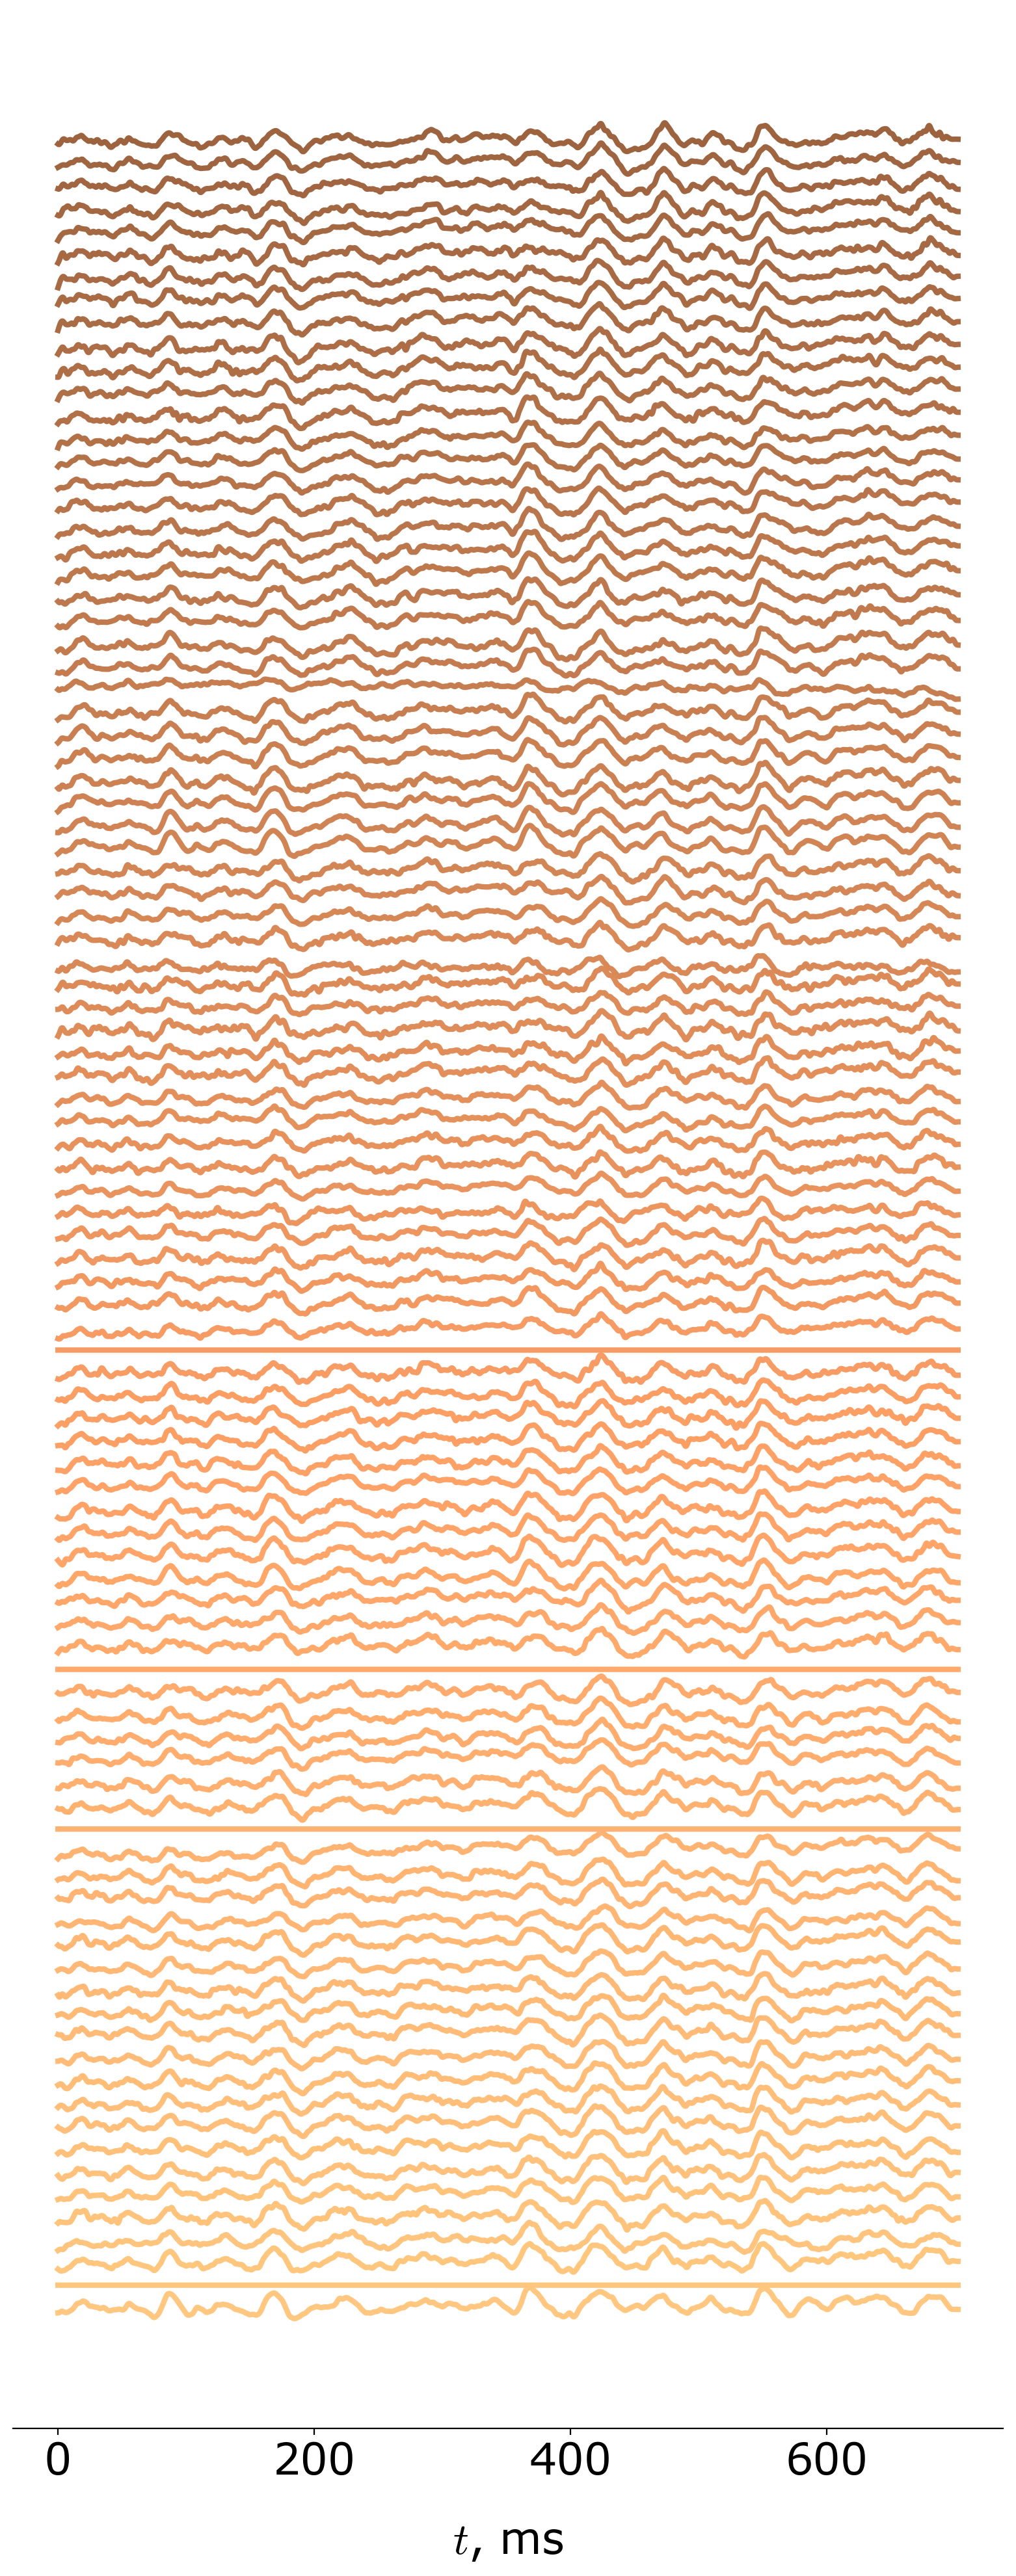

In [15]:
# Plot all targets

rcParams['axes.labelsize'] = 24
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = 24

fig, ax = plt.subplots(figsize=(8, 20), dpi=200)

for i in range(len(targets[0])):
    colors = pl.cm.copper_r(np.linspace(0, 0.5, len(targets[0])))
    ax.plot(rescale_ms, targets[0][i] + i, color=colors[i], lw=3)

ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel(r'$t$, ms')

sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
fig.tight_layout()
plt.savefig('positive_sigmoid_delay/all_targets.png', dpi=200)
plt.show()


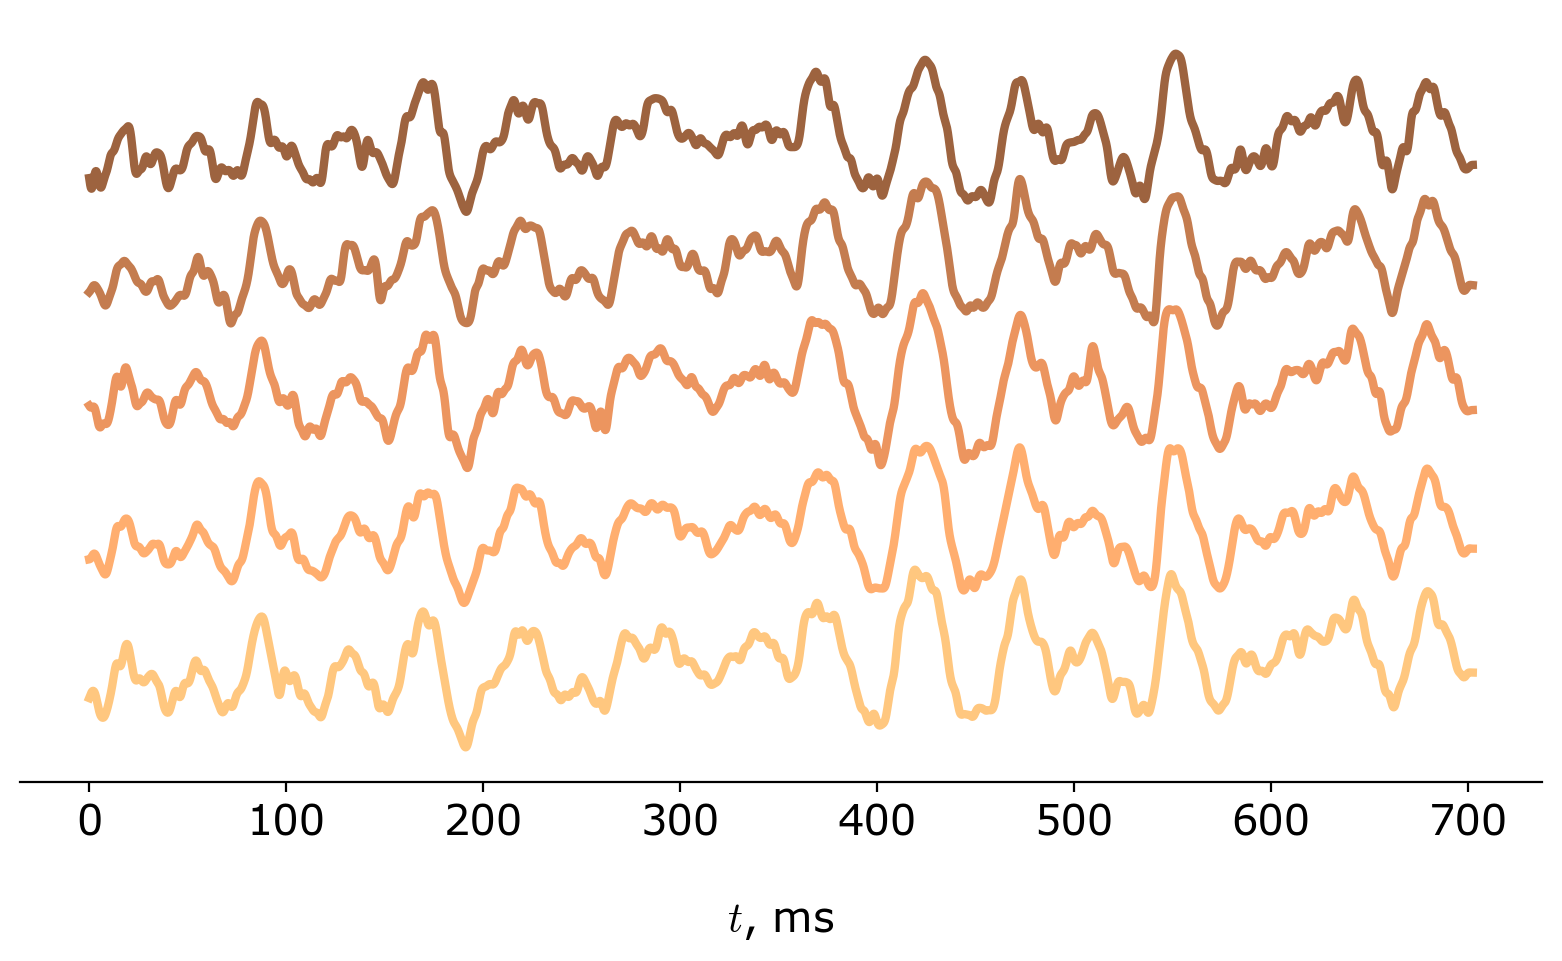

In [14]:
# Plot selection of targets

rcParams['axes.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15

fig, ax = plt.subplots(figsize=(8, 5), dpi=200)

n_to_show = 5

for i in range(n_to_show):
    colors = pl.cm.copper_r(np.linspace(0, 0.5, n_to_show))
    ax.plot(rescale_ms, targets[0][i+10][:max_length] + i, color=colors[i], lw=3)  
                
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel(r'$t$, ms')
sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
fig.tight_layout()
plt.savefig('positive_sigmoid_delay/all_targets.png', dpi=200)
plt.show()



### Gif of targets

In [16]:
# Get indices for location of each unit on electrode 

blackrock_elid_list = bl_raw.annotations['avail_electrode_ids']
corrected = [[-1] if x==-1 else x for x in blackrock_elid_list]
flattened = [val for sublist in corrected for val in sublist]
reshape = np.flip(np.reshape(flattened, (10, 10)), axis=0)
reshape = reshape-1
reshape_unravelled = reshape.ravel()


In [110]:
signal_to_plot = targets[0]

frames = []
scale_limit = 0.8

fig = plt.figure()
plt.axis('off')
for i in np.arange(0, max_length, 50):
    lfp_at_timepoint = signal_to_plot[:, i]
    lfp_reshape = np.reshape(lfp_at_timepoint[reshape_unravelled], (10, 10))
    lfp_reshape_masked = np.ma.masked_where(reshape==-2, lfp_reshape)
    image = plt.imshow(lfp_reshape_masked, cmap='gist_heat', animated=True, vmin=-scale_limit, vmax=scale_limit)
    frames.append([image])
plt.close()

ani = animation.ArtistAnimation(fig, frames, interval=10, blit=True, repeat_delay=1000) 

HTML(ani.to_html5_video())

ani.save('positive_sigmoid_delay/targets0_gif.mp4', writer=writer) 


### Network architecture

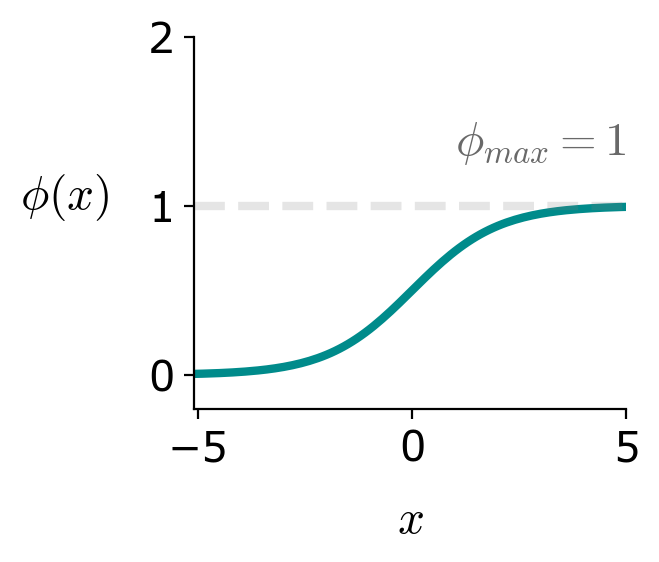

In [22]:
# Plot nonlinearity


rcParams['axes.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15

phi_max = 1
x = np.arange(-10, 10, 0.1)

fig, ax = plt.subplots(figsize=(3.5, 3), dpi=200)
plt.plot(x, nonlinearity(x), color=main_color, lw=3)
ax.axhline(phi_max, ls='--', color='grey', alpha=0.2, lw=3)
ax.text(1, phi_max + 0.3, r'$\phi_{max} = %s$' %phi_max, fontsize=17, color='dimgrey')
ax.set_xlabel(r'$x$', fontsize=17, labelpad=10)
ax.set_ylabel('$\phi(x)}$', fontsize=17, rotation=0, labelpad=30)
ax.set_ylim(-.2, phi_max + 1)
ax.set_xlim(-5.1, 5)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()
plt.show()


In [25]:
# Training parameters 

N = len(targets[0]) # number of neurons
n_targets = len(targets[0]) # number of targets

g = 1.5  # variance of initial connectivity 
tau = 100 # ~2ms membrane time constant
D = 60 # from 0.125 to 0.5 ms
dt_weight_update = 10 # frequency of weight update
alpha = 1 # normalisation factor for P matrix 

T = max_length
dt = 1 
iterations = int(T/dt)  
times = np.linspace(0, T, iterations)

n_train = 10
n_free = 1
n_tot = n_train + n_free 

# Define noise
tau_trial = ms_to_tau(100)
amp_trial = 0.02
tau_baseline = ms_to_tau(30)
amp_baseline = 0.04
amps_baseline = np.linspace(0.00, 0.04, N) # graded amplitudes 
taus_baseline = np.linspace(ms_to_tau(10), ms_to_tau(200), N) # graded timescales 

noise_trial = get_noise(N, 1, tau_trial, amp_trial, 0.0)
noise_baseline = get_noise(N, 1, tau_baseline, amp_baseline, 0.0)
noise_baseline_graded = get_noise(N, 1, taus_baseline, amps_baseline, 0.0) 

J0 = np.random.randn(N, N) * g / np.sqrt(N) 
J = J0.copy()
P = np.eye(n_targets) / alpha 

J_evolution = [] # store connectivity matrix throughout training 
J_evolution.append(J0)
save_J_every = int(n_train/5)

zs_all = []
mses = []
deltas_all = np.zeros(n_targets)  
deltas_all = deltas_all[:, None]

start_time = time.time()

for run in range(n_tot):
    
    print(run)

    xs = np.zeros((N, iterations))  
    zs = np.zeros((N, iterations)) 
    deltas = np.zeros((n_targets, iterations)) 
    mse = []
    
    if run>0:
        xs[:, 0] = last_run
    
    for t in range(D, iterations-1):
        xs[:, t+1] = xs[:, t] + (-xs[:, t] + J.dot(nonlinearity(xs[:, t-D])) + noise_trial[0][:, t] + noise_baseline[0][:, t]) * dt / tau
        r = nonlinearity(xs[:, t+1]) 
        r = r[:, None]    
        zs[:, t+1] = J.dot(np.squeeze(r))

        if run < n_train and t % dt_weight_update == 0:
            
            errs = zs[:n_targets, t+1] - targets[0][:, t+1]
            mse.append(np.mean(errs**2))
            k = P.dot(r[:n_targets])
            rPr = r[:n_targets].T.dot(k)
            c = 1.0 / (1.0 + rPr)
            P = P - c * (k.dot(k.T))
            delta_w = - (c * np.outer(errs, k))
            deltas[:, t] = np.linalg.norm(delta_w, axis=0)
            
            J[:n_targets, :n_targets] += delta_w
            J[np.isclose(J, 0.0, atol=1e-04)] = 0.0
            
    last_run = xs[:, -1]
    
    if run % save_J_every == 0:
        J_current = J.copy()
        J_evolution.append(J_current)
        
    mses.append(np.mean(mse))
    zs_all.append(zs)
    deltas_all = np.concatenate((deltas_all, deltas), axis=1)
    
print('Time elapsed: %.2f' % ((time.time() - start_time)/60) + ' min')

0
1
2
3
4
5
6
7
8
9
10
Time elapsed: 0.20 min


/opt/anaconda3/envs/multielectrode_grasp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/multielectrode_grasp/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


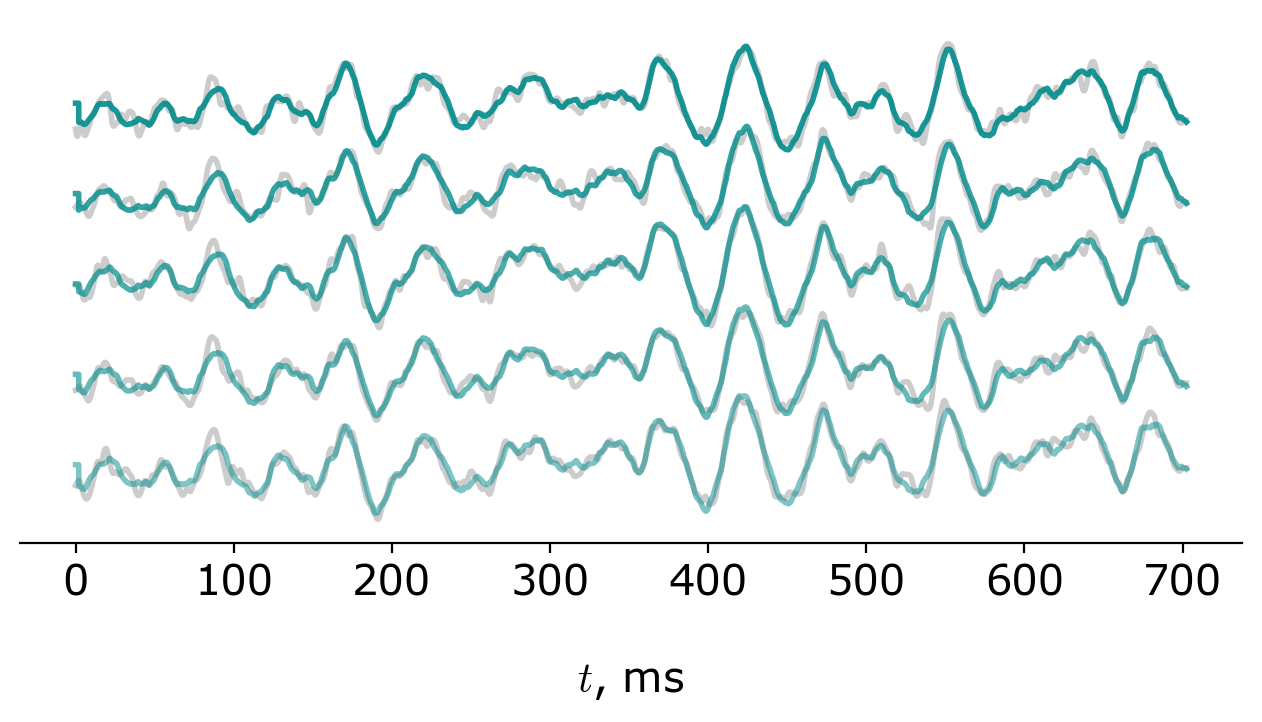

In [28]:
# Plot readout versus target for selection of neurons

fig, ax = plt.subplots(figsize=(6.5, 3.8), dpi=200)

for i in range(10, 15):
    label_target, label_output = None, None
    if i == 14:
        label_target, label_output = 'Target', 'Network output'
    ax.plot(rescale_ms, targets[0][i, :] + i , color='grey', alpha=0.4, linewidth=2, label=label_target)   # Target functions
    ax.plot(rescale_ms, zs_all[-1][i, :] + i , color='darkcyan', alpha=((i/10 - 1)+0.5), linewidth=2, label=label_output)  # Network presynaptic currents
#     ax.plot(rescale_ms, xs[i, :] + i , color='darkcyan', alpha=((i/10 - 1)+0.5), linewidth=2, label=label_output)  # Network activations

ax.set_xlabel('$t$, ms', labelpad=20)
ax.set_yticks([])
ax.set_yticklabels([])
sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
fig.tight_layout()
plt.savefig('positive_sigmoid_delay/sample_dynamics.png', dpi=200)
plt.show()


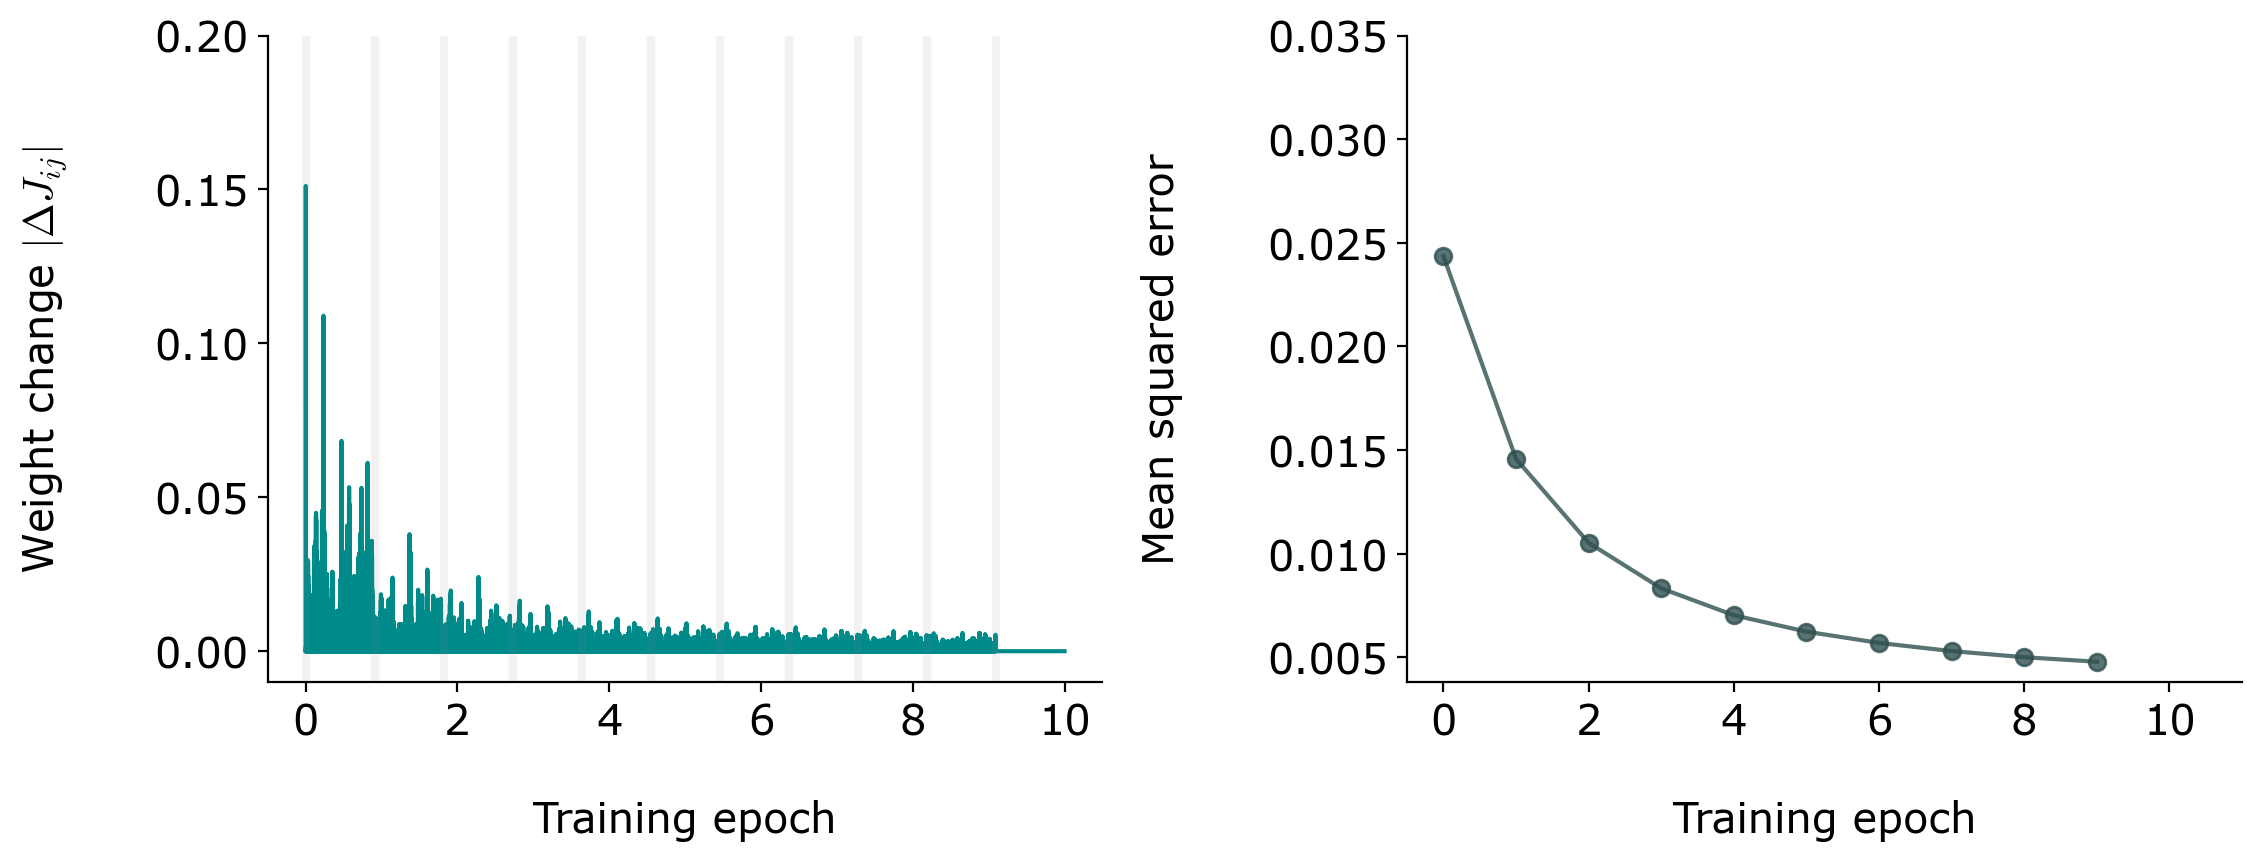

In [29]:
# Weight change and error over learning

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.5, 4.5), dpi=200)

delta_xaxis = np.linspace(0, len(deltas_all[0]), int((n_tot+1)/2))

ax1.plot(deltas_all[0], color=main_color)
ax1.set_ylabel(r'Weight change $| \Delta J_{ij} |$', rotation=90, labelpad=30)
ax1.set_xlabel('Training epoch')
ax1.set_ylim(-0.01, 0.2)
ax1.set_xticks(delta_xaxis)
ax1.set_xticklabels(np.arange(0, n_tot, 2))
for epoch in range(n_tot):
    ax1.axvline(iterations*epoch, color='grey', lw=3, alpha=0.1)

ax2.plot(mses[:-(n_free)], marker='o', color=main_color_dark, alpha=0.8)
ax2.set_ylabel(r'Mean squared error', labelpad=30)
ax2.set_xlabel('Training epoch')
ax2.set_xlim(-0.5, n_tot)
ax2.set_ylim(None, 0.035)
sns.despine(ax=ax1, top=True, right=True)
sns.despine(ax=ax2, top=True, right=True)
fig.tight_layout()
plt.savefig('positive_sigmoid_delay/weight_change.png', dpi=200)
plt.show()

### Trained connectivity matrix 

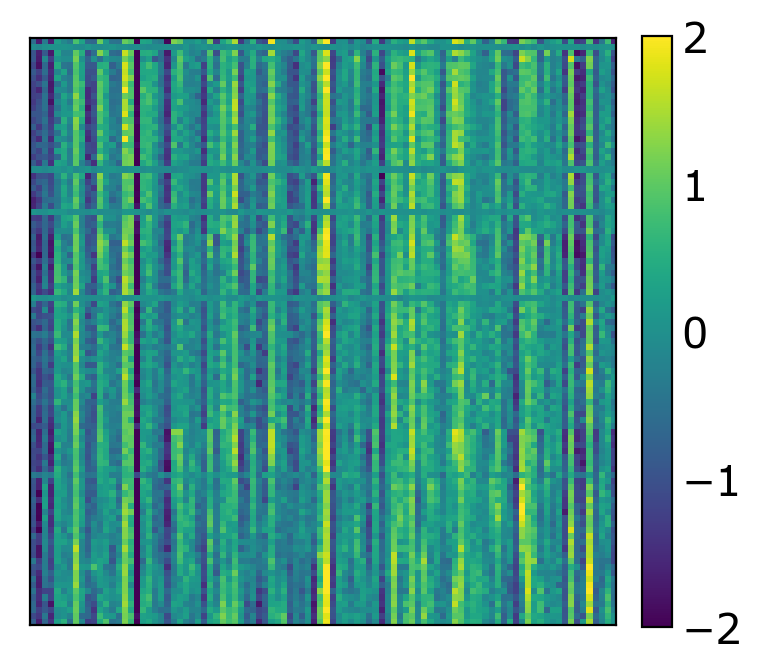

In [30]:
# Visualise matrix as heatmap

fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

J_masked = np.ma.masked_where(J==0, J)

scale_limit = 2
im = plt.imshow(J, cmap='viridis', vmin=-scale_limit, vmax=scale_limit)
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.tick_params(size=0)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('positive_sigmoid_delay/trained_matrix.png', dpi=200)
plt.show()

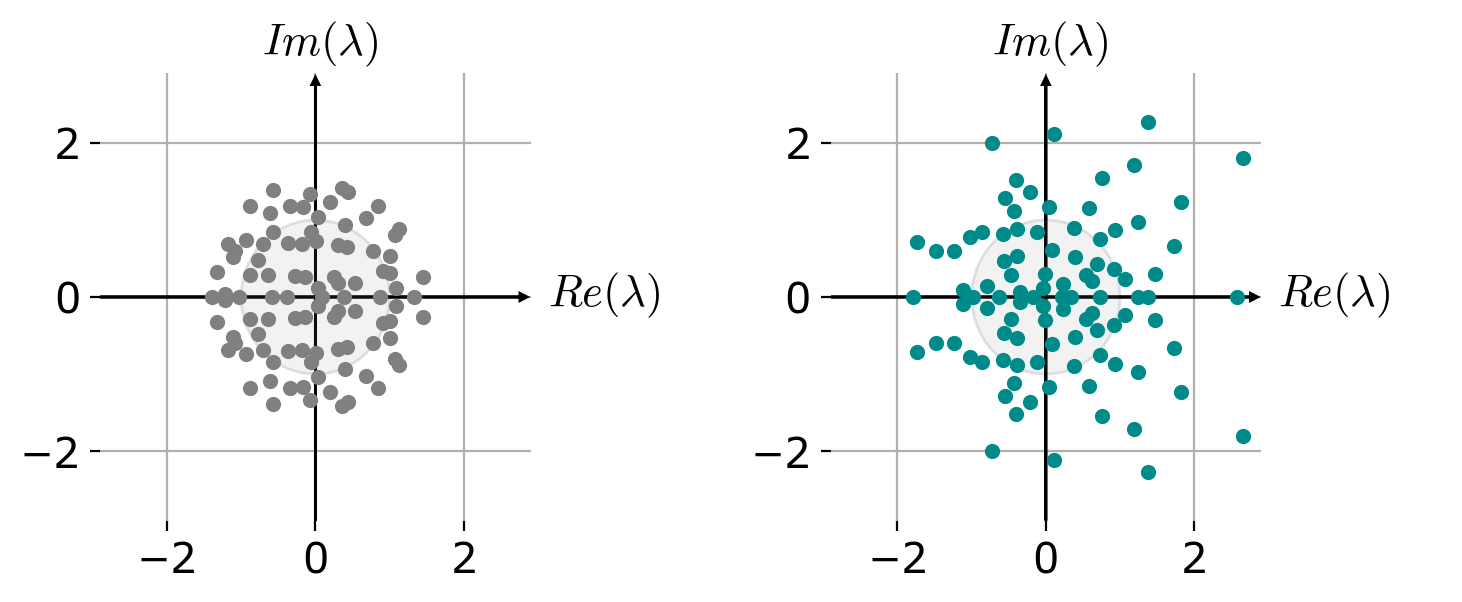

In [31]:
# Eigenspectrum of connectivity matrix

eigvals_J, eigvecs_J = np.linalg.eig(J) 
eigvals_J0, eigvecs_J0 = np.linalg.eig(J0) 

w = 2.9

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 3.2), dpi=200)

for ax in (ax1, ax2):
    ax.grid()
    ax.text(-0.25 * w, 1.08 * w, r'$Im(\lambda)$', fontsize=16)
    ax.text(1.08 * w,  -0.04 * w, r'$Re(\lambda)$    ', fontsize=16)
    ax.set_xlim(-w, w)
    ax.set_ylim(-w, w)
    ax.arrow(0, -w, 0, 1.95 * w, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
    ax.arrow(-w, 0, 1.95 * w, 0, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
    circle = plt.Circle((0,0), 1, facecolor='grey', alpha=0.1, fill=True, edgecolor='k')
    ax.add_artist(circle)
    sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
    ax.set_axisbelow(True)
    
for eigval in eigvals_J0:
    ax1.scatter(eigval.real, eigval.imag, color='grey', s=20, zorder=3)

for eigval in eigvals_J:
    ax2.scatter(eigval.real, eigval.imag, color=main_color, s=20, zorder=3)

plt.tight_layout()
plt.savefig('positive_sigmoid_delay/eigenvalues_J.png', dpi=200)
plt.show()

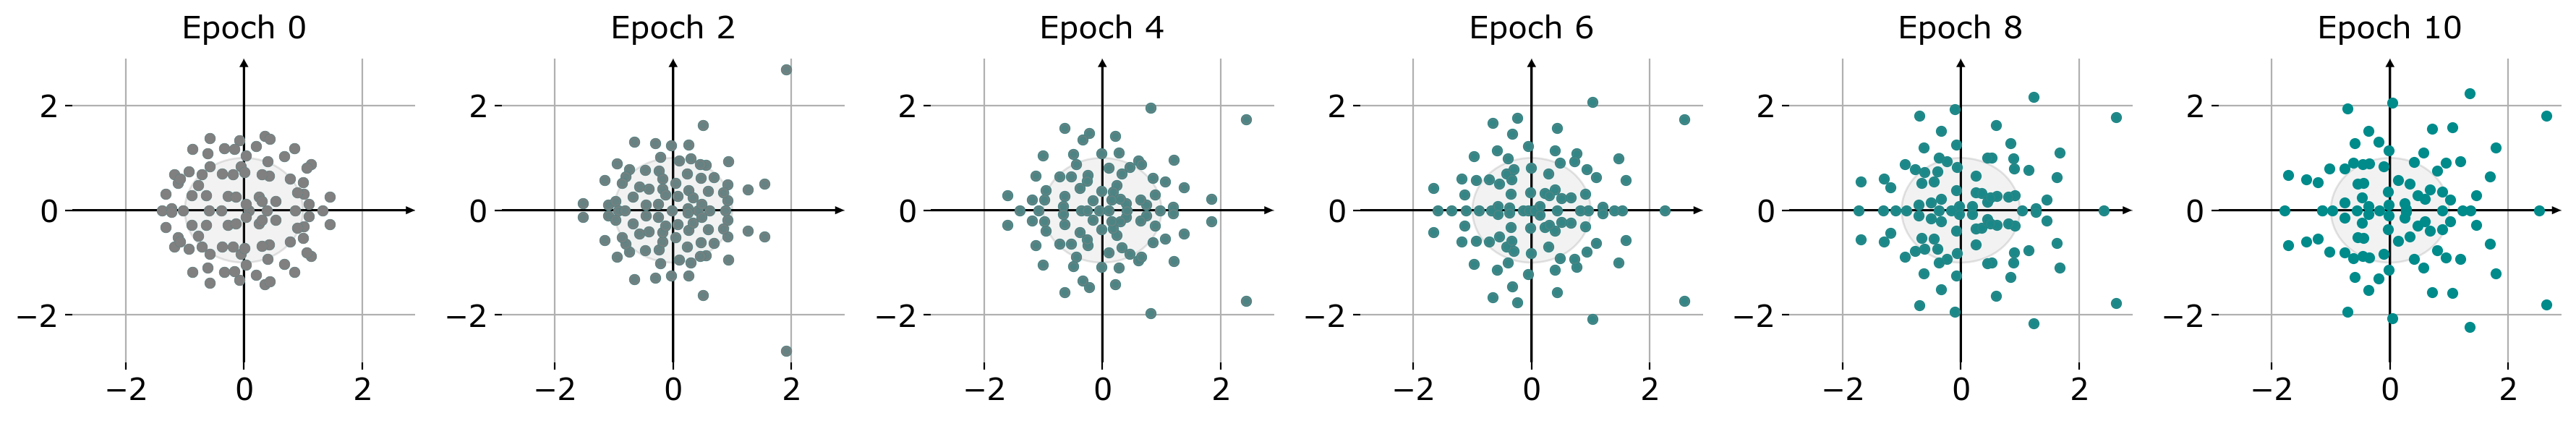

In [32]:
# Plot eigenvalue change over learning 

fig, axs = plt.subplots(1, len(J_evolution)-1, figsize=(18, 3.1), dpi=200)

w = 2.9

alphas = np.linspace(0, 1, len(axs))[::-1] 

for idx, ax in enumerate(axs):
    ax.grid()
    ax.set_xlim(-w, w)
    ax.set_ylim(-w, w)
    ax.arrow(0, -w, 0, 1.95 * w, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
    ax.arrow(-w, 0, 1.95 * w, 0, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
    circle = plt.Circle((0,0), 1, facecolor='grey', alpha=0.1, fill=True, edgecolor='k')
    ax.add_artist(circle)
    sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
    ax.set_axisbelow(True)
    ax.set_title('Epoch %d' % int(save_J_every*idx))

    eigvals, eigvecs = np.linalg.eig(J_evolution[idx]) 

    for i in range(len(eigvals)):
        x = eigvals[i].real
        y = eigvals[i].imag
        ax.scatter(x, y, color=main_color, s=20, zorder=3)
        ax.scatter(x, y, color='grey', alpha = alphas[idx], s=20, zorder=3)
    
plt.tight_layout()
plt.savefig('positive_sigmoid_delay/eigenvalues_evolution_J.png', dpi=200)
plt.show()


### Autonomous dynamics

Excitatory covariance -0.4383580668168123
Inhibitory covariance -0.08416553142365536


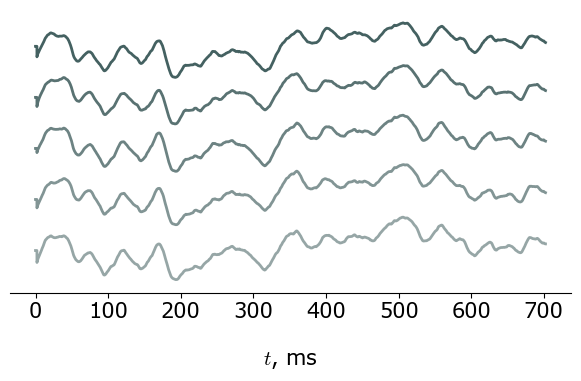

In [36]:
# Run network autonomously 

noise_trial_new = get_noise(N, 1, tau_trial, amp_trial, 0.0)
noise_baseline_new = get_noise(N, 1, tau_baseline, amp_baseline, 0.0)

noise_indices = np.argsort(np.mean(J, axis=0))

x1a = np.zeros((N, iterations))
zs_noise = np.zeros((N, iterations-1)) 

for t in range(D, iterations-1):
    x1a[:, t+1] = x1a[:, t] + (-x1a[:, t] + J.dot(nonlinearity(x1a[:, t-D])) + noise_trial_new[0][:, t]) * dt / tau
    zs_noise[:, t] = J.dot(nonlinearity(x1a[:, t+1]))
    
threshold = 5
excitatory_mean = np.mean(noise_baseline_new[0][noise_indices[-threshold:]], axis=0)[:-1]
inhibitory_mean = np.mean(noise_baseline_new[0][noise_indices[:threshold]], axis=0)[:-1]
response_mean = np.mean(zs_noise, axis=0)

print('Excitatory covariance', np.dot(excitatory_mean - excitatory_mean.mean(), response_mean - response_mean.mean())/(N-1))
print('Inhibitory covariance', np.dot(inhibitory_mean - inhibitory_mean.mean(), response_mean - response_mean.mean())/(N-1))
                    
# Plot currents over timecourse of target
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

for i in range(10, 15): 
    ax.plot(rescale_ms[:-1], zs_noise[i, :max_length-1] + i , color=main_color_dark, alpha=((i/10 - 1)+0.5), linewidth=2)
    
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('$t$, ms', labelpad=20)
sns.despine(ax=ax, top=True, right=True, left=True)
fig.tight_layout()
plt.savefig('positive_sigmoid_delay/novel_noise.png', dpi=200)
plt.show()


### Gif of novel noise response

In [151]:
signal_to_plot = zs_noise

frames = []
scale_limit = 2

fig = plt.figure()
plt.axis('off')
for i in np.arange(0, max_length, 50):
    lfp_at_timepoint = signal_to_plot[:, i]
    lfp_reshape = np.reshape(lfp_at_timepoint[reshape_unravelled], (10, 10))
    lfp_reshape_masked = np.ma.masked_where(reshape==-2, lfp_reshape)
    image = plt.imshow(lfp_reshape_masked, cmap='gist_heat', animated=True, vmin=-scale_limit, vmax=scale_limit)
    frames.append([image])
plt.close()

ani = animation.ArtistAnimation(fig, frames, interval=10, blit=True, repeat_delay=1000) 

HTML(ani.to_html5_video())


In [152]:
ani.save('positive_sigmoid_delay/zs_noise_gif.mp4', writer=writer) 

In [38]:
# Noise correlation analysis 

repeats = 10

thresholds = np.arange(1, 51, 1)

excitatory_inhibitory_means_all = []
excitatory_inhibitory_stds_all = []

excitatory_correlations_all = []
inhibitory_correlations_all = []

for threshold in thresholds:
    
    excitatory_correlations = []
    inhibitory_correlations = []

    for i in range(repeats):

        new_noise = get_noise(N, 1, ms_to_tau(30), 0.02, 0.0)
        noise_baseline_new = get_noise(N, 1, ms_to_tau(200), 0.04, 0.0)

        x1a = np.zeros((N, iterations))
        zs_noise = np.zeros((N, iterations-1)) 

        for t in range(D, iterations-1):
            x1a[:, t+1] = x1a[:, t] + (-x1a[:, t] + J.dot(nonlinearity(x1a[:, t-D])) + new_noise[0][:, t] + noise_baseline_new[0][:, t]) * dt / tau
            zs_noise[:, t] = J.dot(nonlinearity(x1a[:, t+1]))

        excitatory_mean = np.mean(noise_baseline_new[0][noise_indices[-threshold:]], axis=0)[:-1]
        inhibitory_mean = np.mean(noise_baseline_new[0][noise_indices[:threshold]], axis=0)[:-1]
        response_mean = np.mean(zs_noise, axis=0)
        
        excitatory_correlations.append(np.dot(excitatory_mean - excitatory_mean.mean(), response_mean - response_mean.mean())/(N-1))
        inhibitory_correlations.append(np.dot(inhibitory_mean - inhibitory_mean.mean(), response_mean - response_mean.mean())/(N-1))
        
    excitatory_inhibitory_means_all.append([np.mean(excitatory_correlations), np.mean(inhibitory_correlations)])
    excitatory_inhibitory_stds_all.append([np.std(excitatory_correlations), np.std(inhibitory_correlations)])
    
    excitatory_correlations_all.append(excitatory_correlations)
    inhibitory_correlations_all.append(inhibitory_correlations)

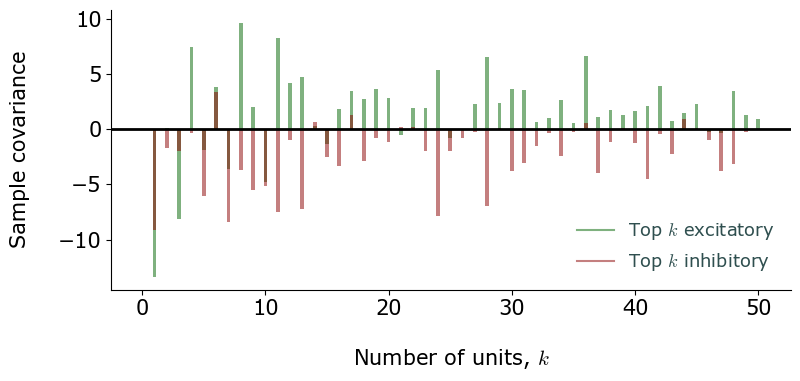

In [39]:
fig, ax = plt.subplots(figsize=(8.2, 4), dpi=100)

for ind, thresh in enumerate(thresholds):
    
    ax.bar(thresh, excitatory_inhibitory_means_all[ind], width=0.3, color=(positive_color, negative_color), alpha=0.5, 
           linewidth=2, capsize=5)

ax.plot(0, 0, color=positive_color, alpha=0.5, label=r'Top $k$ excitatory')
ax.plot(0, 0, color=negative_color, alpha=0.5, label=r'Top $k$ inhibitory')

ax.axhline(0, color='k', lw=2)
ax.set_ylabel('Sample covariance')
ax.set_xlabel('Number of units, $k$')
legend = ax.legend(frameon=False, loc=0, fontsize=13)
plt.setp(legend.get_texts(), color='darkslategrey')
sns.despine(ax=ax, top=True, right=True, left=False)
fig.tight_layout()
plt.show()


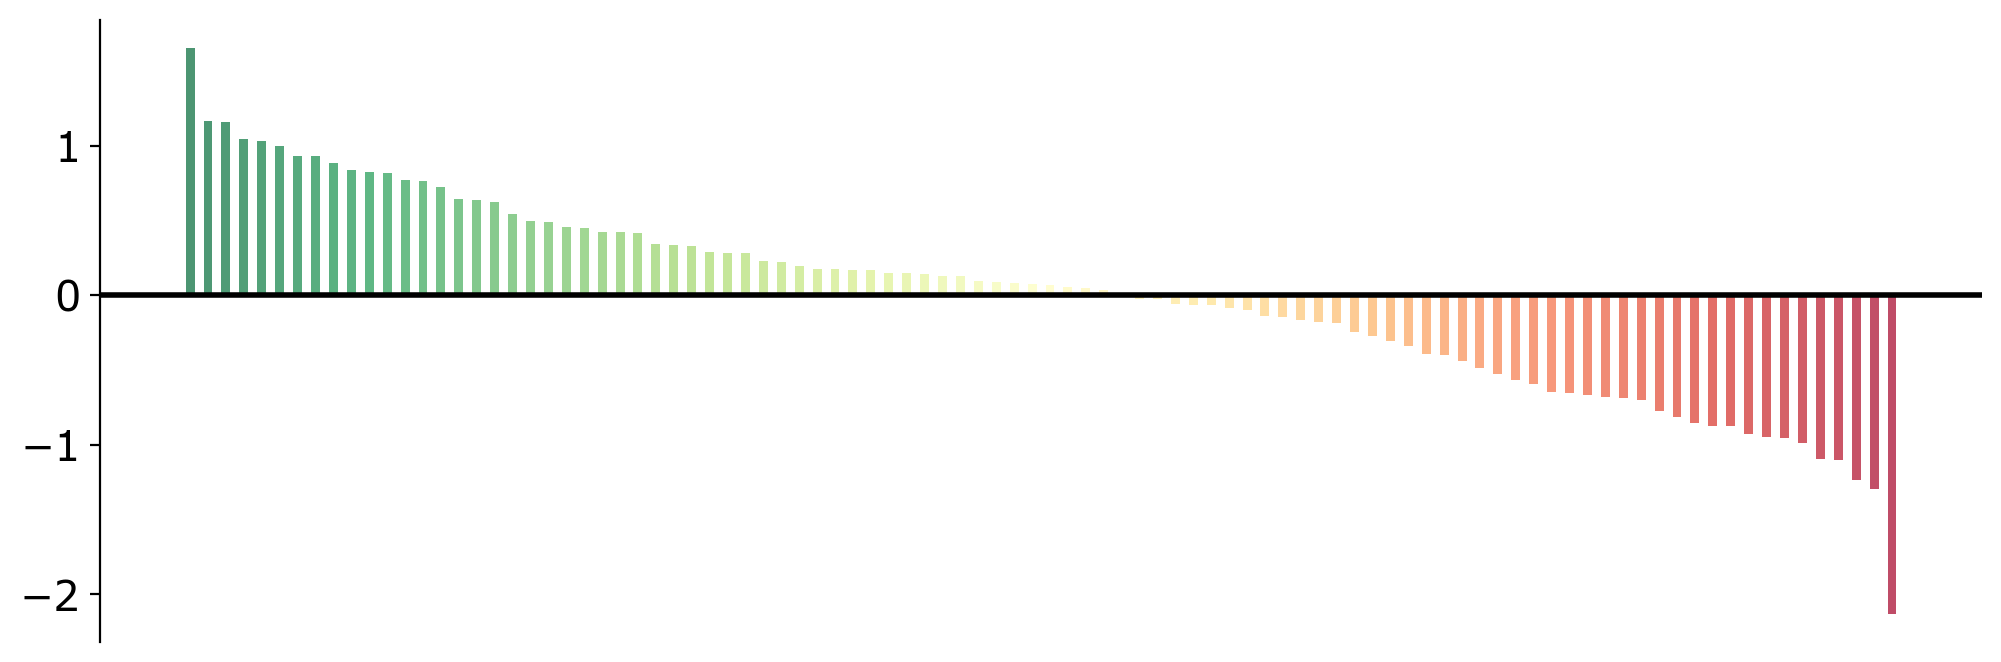

In [40]:
# Mean outgoing weights ordered by strength 

fig, ax = plt.subplots(figsize=(10.2, 3.5), dpi=200)
red_green = pl.cm.RdYlGn(np.linspace(1, 0, N))
ax.bar(np.arange(0, N), sorted(np.mean(J, axis=0), reverse=True), width=0.5, color=red_green, alpha=0.7, 
           linewidth=2)
ax.axhline(0, color='k', lw=2)
ax.get_xaxis().set_visible(False)
sns.despine(ax=ax, top=True, right=True, bottom=True, left=False)
fig.tight_layout()
plt.show()


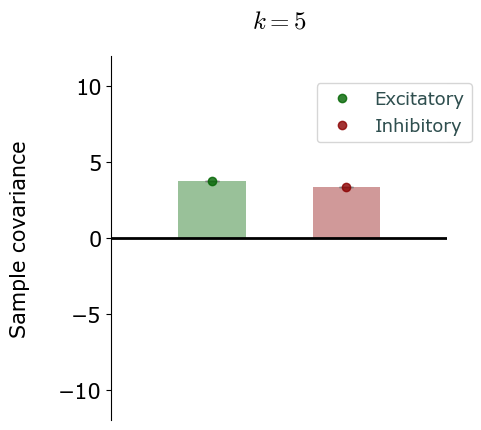

In [41]:
# Correlation of network dynamics with mean of noise input to first k units 

fig, ax = plt.subplots(figsize=(5, 4.5), dpi=100)

k = 5
ax.bar([0.3, 0.7], excitatory_inhibitory_means_all[k], width=0.2, color=(positive_color, negative_color), alpha=0.4, 
       linewidth=2, 
       yerr=excitatory_inhibitory_stds_all[k], ecolor='grey',
       capsize=5)
ax.plot(np.ones(repeats)*0.3, excitatory_correlations_all[k], 'o', color=positive_color, alpha=0.8, label='Excitatory')
ax.plot(np.ones(repeats)*0.7, inhibitory_correlations_all[k], 'o', color=negative_color, alpha=0.8, label='Inhibitory')
ax.axhline(0, color='k', lw=2)
ax.set_ylim(-12, 12)
ax.set_xlim(0, 1)
ax.set_ylabel('Sample covariance')
ax.get_xaxis().set_visible(False)
ax.set_title('$k = %s$' %k, fontsize=18, pad=20)
legend = ax.legend(frameon=True, loc=1, bbox_to_anchor=[1.1, 0.95], fontsize=13)
plt.setp(legend.get_texts(), color='darkslategrey')
sns.despine(ax=ax, top=True, right=True, bottom=True, left=False)
fig.tight_layout()
plt.show()

### Correlation of noise with beta spindles

In [42]:
def butter_bandpass(lowcut, highcut, fs, order=5):  # fs = sampling frequency 
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def get_beta_boundaries(signal_to_filter, lowcut, highcut, fs, power_threshold):
    
    filtered_signal = butter_bandpass_filter(signal_to_filter, lowcut, highcut, fs, order=2)[:max_length]
    condition_met = np.arange(max_length-1)[(filtered_signal >= power_threshold) + (filtered_signal <= -power_threshold)]
    
    if len(condition_met) > 0:
        all_boundaries = [condition_met[0]]
        for ind in range(len(condition_met)-1):
            if condition_met[ind+1] - condition_met[ind] != 1:
                all_boundaries.append(condition_met[ind])
                all_boundaries.append(condition_met[ind+1])
        boundaries = [all_boundaries[0]]
        for ind in range(len(all_boundaries)):
            if all_boundaries[ind] - all_boundaries[ind-1] > 2000:
                boundaries.append(all_boundaries[ind])
                boundaries.append(all_boundaries[ind-1])
        boundaries.append(all_boundaries[-1])
        return sorted(boundaries)
    else:
        return []
    

def create_step_current(boundaries, amp_step):
    step_current = np.zeros(max_length)
    intervals = [np.arange(boundaries[x], boundaries[x+1]) for x in range(len(boundaries)-1)]
    step_current[np.concatenate(intervals[::2])] = 1 * amp_step
    return step_current

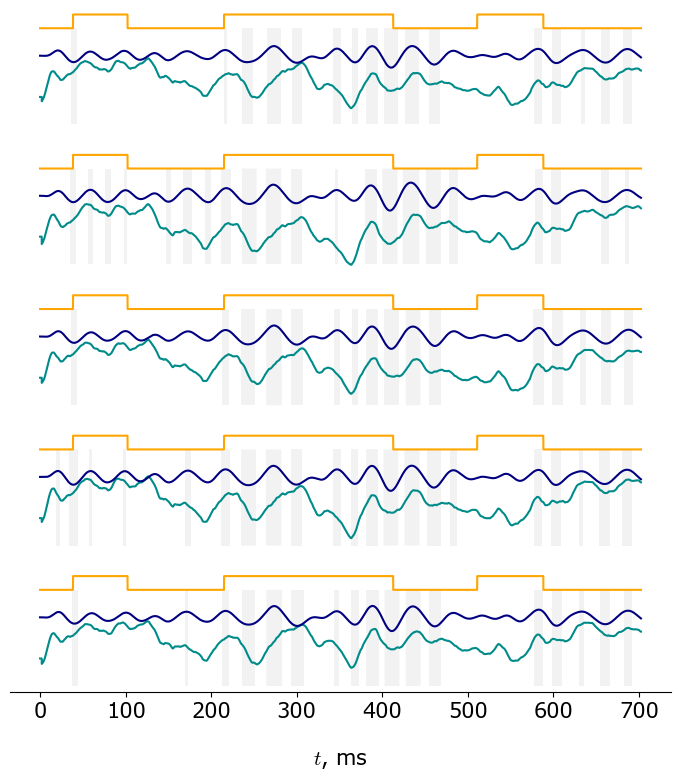

In [43]:
# Parameters for filtering
fs = 1 / ((rescale_ms[-1].magnitude / max_length) / 1000) # samples per second
lowcut = 15
highcut = 30
order = 2
power_threshold = 0.2

# Get mean boundaries for beta peaks  
boundaries_all = []
for response in zs_noise:
    signal_to_filter = response[:max_length]
    boundaries = get_beta_boundaries(signal_to_filter, lowcut, highcut, fs, power_threshold)
    boundaries_all.append(boundaries)
mode_length = stats.mode([len(x) for x in boundaries_all])[0]
boundaries_means = np.mean([x for x in boundaries_all if len(x) == mode_length], axis=0).astype(int)    

# Create step current from boundaries 
amp_step = 0.5
step_current = create_step_current(boundaries_means, amp_step)

# Plot targets, beta-filtered targets and step currents

n_to_plot = 5

fig, axs = plt.subplots(n_to_plot, 1, figsize=(7, 8), dpi=100)
for ind, ax in enumerate(axs):
    signal_to_filter = zs_noise[ind + 5, :max_length]
    filtered_signal = butter_bandpass_filter(signal_to_filter, lowcut, highcut, fs, order=2)[:max_length]
    ax.plot(rescale_ms[:-1], signal_to_filter, color=main_color, label='Original signal')
    ax.plot(rescale_ms[:-1], filtered_signal + 1.5, color='navy', label='Filtered signal')
    ax.plot(rescale_ms, step_current + 2.5, color='orange')
    ax.fill_between(rescale_ms[:-1], -1, 2.5, where=(filtered_signal >= power_threshold) + (filtered_signal <= -power_threshold), color='grey', alpha=0.1, ec=None)
    ax.get_yaxis().set_visible(False)
    sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
    if ind != n_to_plot-1:
        ax.get_xaxis().set_visible(False)
        sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)

axs[-1].set_xlabel('$t$, ms', labelpad=20)
fig.tight_layout()
plt.show()



### Fourier analysis of new noise response

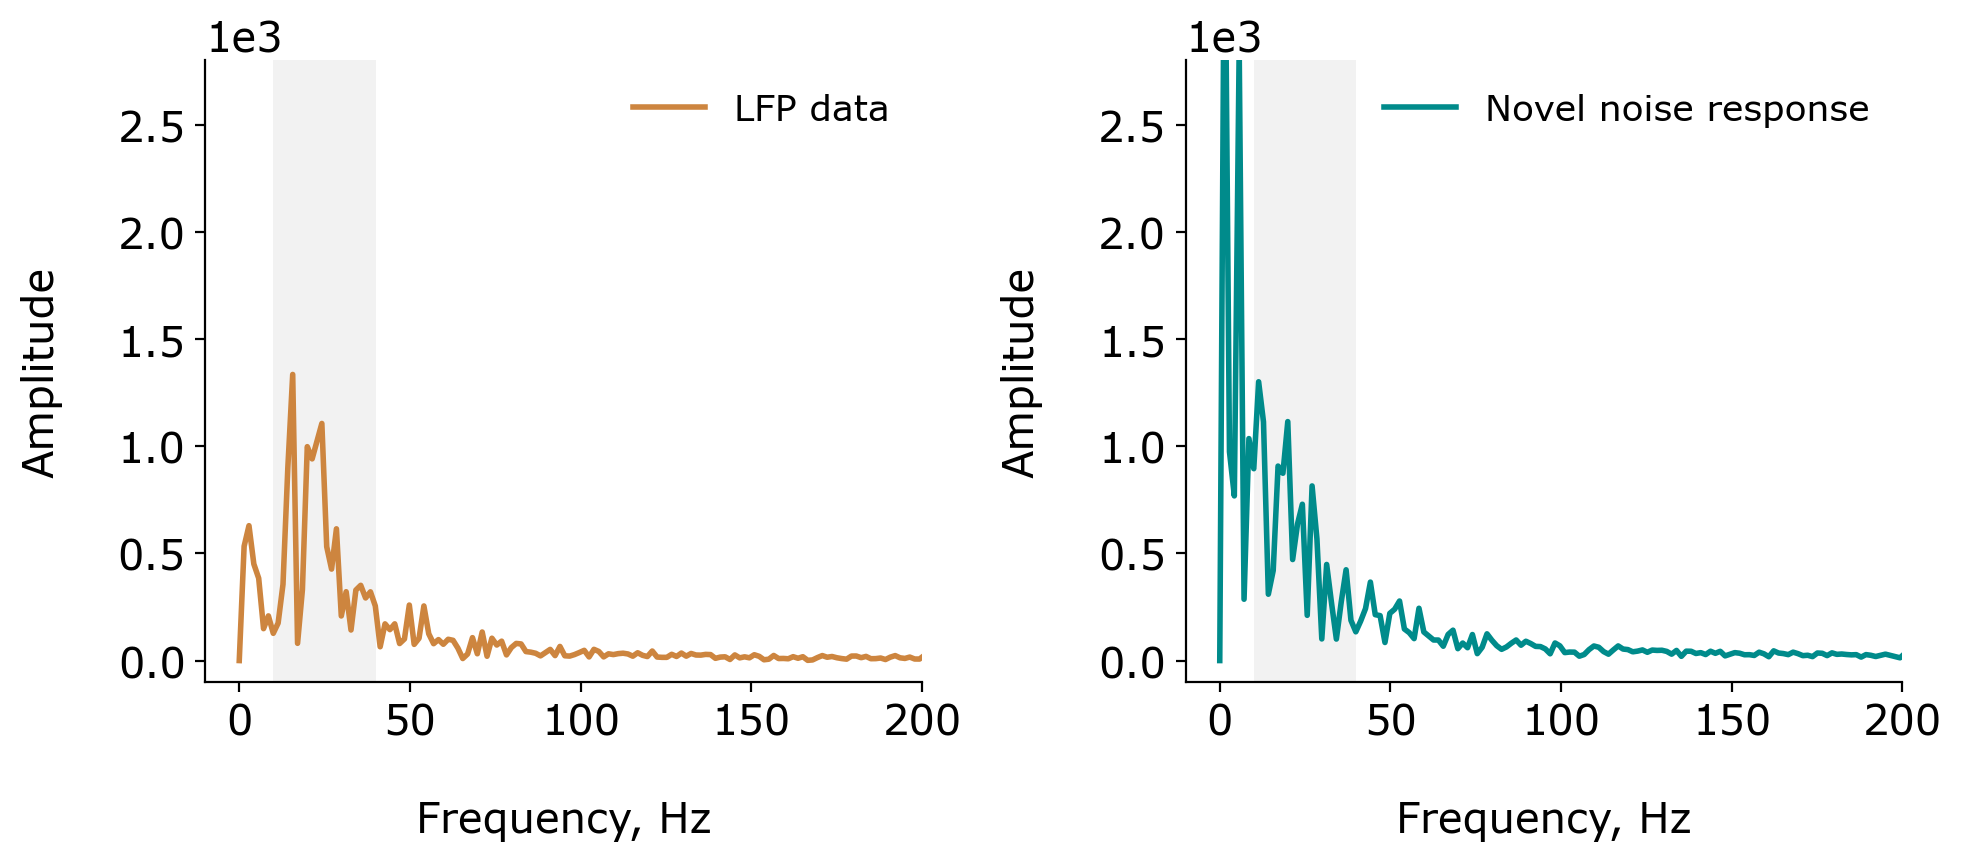

In [44]:
# Fourier analysis of new noise response

trained_response_all = []
noise_response_all = []

for i in range(n_targets):
    trained_response = targets[0][i] - targets[0][i].mean()
    yf_trained = rfft(trained_response)
    trained_response_all.append(yf_trained)
    noise_response = zs_noise[i] - zs_noise[i].mean()
    
    yf_noise = rfft(noise_response)
    noise_response_all.append(yf_noise)

trained_response_avg = np.mean(trained_response_all, axis=0)
noise_response_avg = np.mean(noise_response_all, axis=0)

duration_s = float(rescale_ms[-1].magnitude) / 1000  # duration in seconds
sample_rate = len(noise_response)/duration_s  # number of samples per second

xf_noise = rfftfreq(noise_response.size, 1/sample_rate)
xf_trained = rfftfreq(trained_response.size, 1/sample_rate)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5), dpi=200)

ax1.plot(xf_trained, np.abs(trained_response_avg), color='peru', lw=2, label='LFP data')
ax2.plot(xf_noise, np.abs(noise_response_avg), color=main_color, lw=2, label='Novel noise response')

for ax in (ax1, ax2):
    ax.set_xlim(-10, 200)
    ax.set_ylim(-100, 2.8*10**3)
    ax.set_xlabel('Frequency, Hz', labelpad=20)
    ax.set_ylabel('Amplitude', labelpad=20)
    ax.axvspan(10, 40, color='grey', ec=None, alpha=0.1)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=True, useMathText=None)
    ax.legend(frameon=False, loc=0, fontsize=13)
    sns.despine(ax=ax, top=True, right=True)
    
fig.tight_layout()
plt.savefig('positive_sigmoid_delay/fourier_spectrum.png', dpi=200)
plt.show()

### Autocorrelation function of noise response

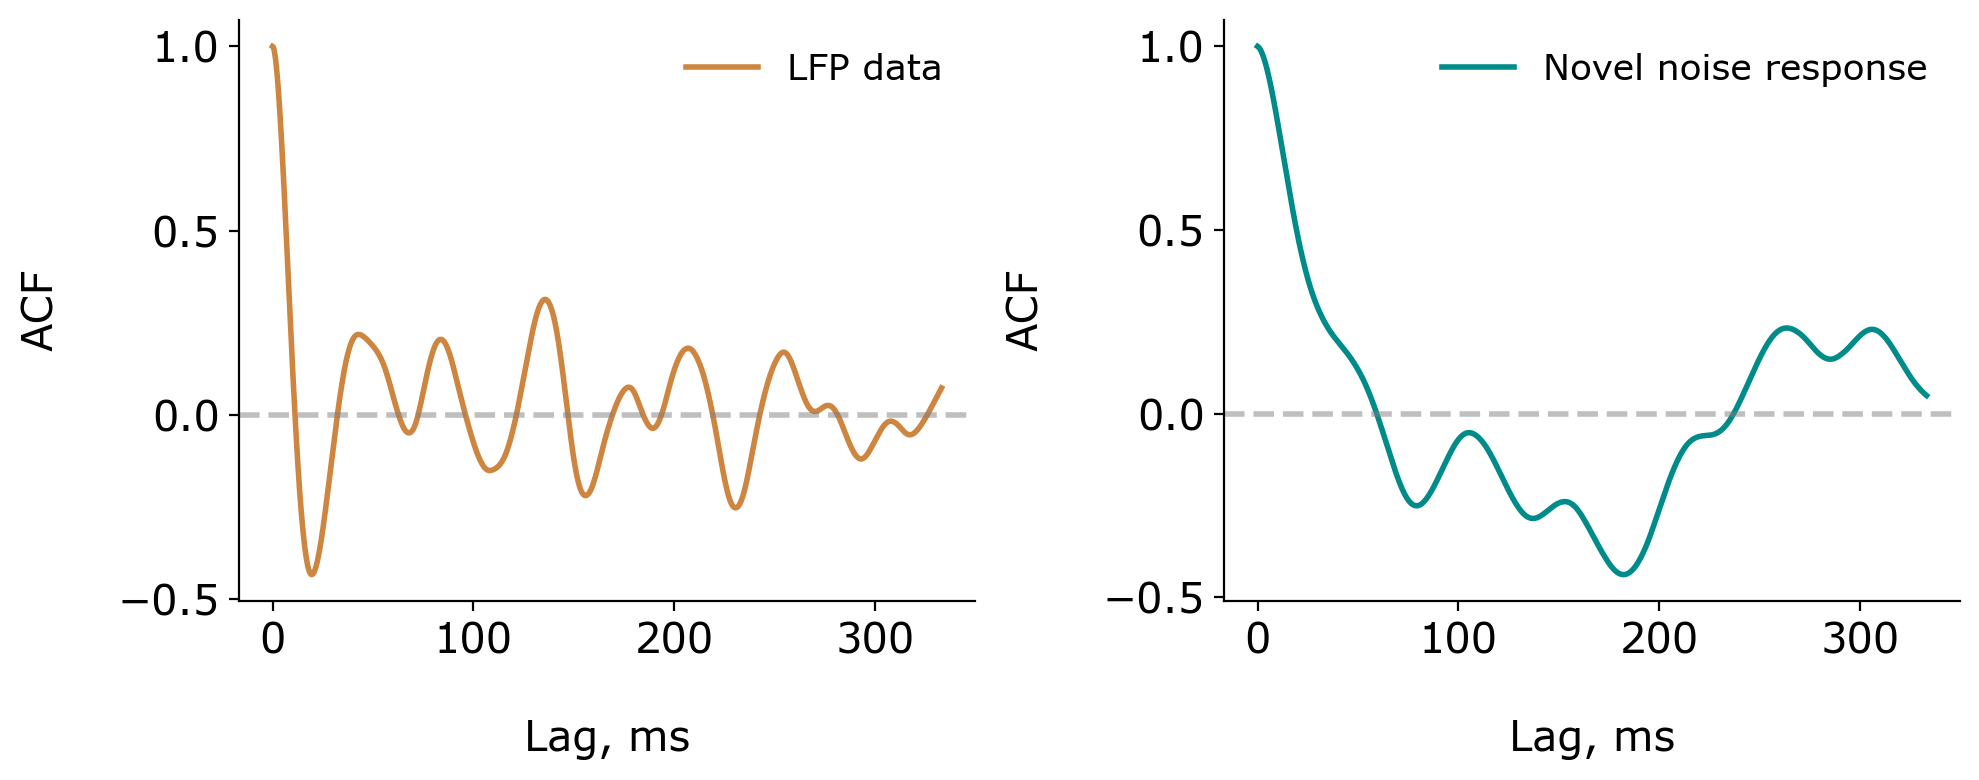

In [458]:
# Autocorrelation of new noise response

lags=range(10000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

iterations_to_ms = float(rescale_ms[-1].magnitude) / max_length

ax1.plot(np.arange(0, len(lags))*iterations_to_ms, autocorr(targets[0][0], lags), lw=2, color='peru', label='LFP data')
ax2.plot(np.arange(0, len(lags))*iterations_to_ms, autocorr(zs_noise[8], lags), lw=2, color=main_color, label='Novel noise response')

for ax in (ax1, ax2):
    ax.axhline(0, color='grey', alpha=0.5, lw=2, ls='--')
    ax.set_xlabel('Lag, ms', labelpad=20) # convert to ms
    ax.set_ylabel('ACF', labelpad=20)

    ax.legend(frameon=False, loc=0, fontsize=13)
    sns.despine(ax=ax, top=True, right=True)
    
fig.tight_layout()
plt.savefig('positive_sigmoid_delay/autocorrelation.png', dpi=200)
plt.show()



### Response to pulse input

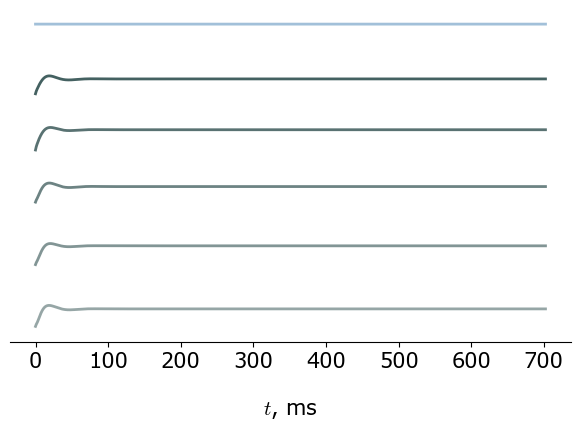

In [45]:
# Run network autonomously with input pulse

amp_pulse = 1
duration_pulse = 200
start_pulse = int(iterations/4)
stop_pulse = int(start_pulse + duration_pulse)

pulse_input = np.zeros((N, iterations))
# pulse_input[:, start_pulse:stop_pulse] = np.tile(eigvecs_jacobian[0].real[:, None], duration_pulse) * 10
# pulse_input[:, start_pulse:stop_pulse] = np.tile(np.random.randn(N)[:, None], duration_pulse) * 2

x1a = np.zeros((N, iterations))
zsa = np.zeros((N, iterations-1)) 

for t in range(iterations-1):
    x1a[:, t+1] = x1a[:, t] + (-x1a[:, t] + J.dot(nonlinearity(x1a[:, t-D])) + pulse_input[:, t]) * dt / tau
    zsa[:, t] = J.dot(nonlinearity(x1a[:, t+1]))
                    
# Plot currents over timecourse of target
fig, ax = plt.subplots(figsize=(6, 4.5), dpi=100)
for i in range(10, 15): 
    ax.plot(rescale_ms[:-1], zsa[i, :max_length-1] + i , color=main_color_dark, alpha=((i/10 - 1)+0.5), linewidth=2)
ax.plot(rescale_ms, pulse_input[0] + 15, color='steelblue', lw=2, alpha=0.5)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel(r'$t$, ms', labelpad=20)
sns.despine(ax=ax, top=True, right=True, left=True)
fig.tight_layout()
plt.show()



### Linear stability analysis

In [47]:
def system(x, J, D):
    return (-x + J.dot(nonlinearity(x-D/tau)))/tau 

def q(x, J):
    return 1/2 * np.linalg.norm(system(x, J))**2

# Fixed point found by running the dynamics
fixed_point = zsa[:, -1]

# Other possible fixed points
# selected_indices = random.sample(range(0, len(targets[0])), k=10)
# initial_conditions = []
# for si in selected_indices:
#     initial_conditions.append(zs_all[-1][:, si])
# xopts = []
# for in_cond in initial_conditions:
#     result = optimize.minimize(q, in_cond, J)
#     xopts.append(result.x)

# Define Jacobian
jacobian_sys = nd.Jacobian(system)
jacobian_fp = jacobian_sys(fixed_point, J, D)

# Get eigenvalues of Jacobian at fixed point
eigvals_jacobian, eigvecs_jacobian = np.linalg.eig(jacobian_fp)  # units of eigvals = 1/t ?

# Sort eigenvalues in descending order
idx = eigvals_jacobian.argsort()[::-1]   
eigvals_jacobian = eigvals_jacobian[idx]
eigvecs_jacobian = eigvecs_jacobian[:,idx]

In [49]:
# Frequency of oscillations

print('Frequency: ', eigval_to_hz(max(eigvals_jacobian.imag)))
print('Max real:', max(eigvals_jacobian.real), '  Index', np.argmax(eigvals_jacobian.real))
print('Min real:', min(eigvals_jacobian.real), '  Index', np.argmin(eigvals_jacobian.real))
print('Max imag:', max(eigvals_jacobian.imag), '  Index', np.argmax(eigvals_jacobian.imag))


Frequency:  25.54001437854256
Max real: -0.0037235555978864694   Index 0
Min real: -0.014107336456226437   Index 94
Max imag: 0.005348834278893657   Index 10


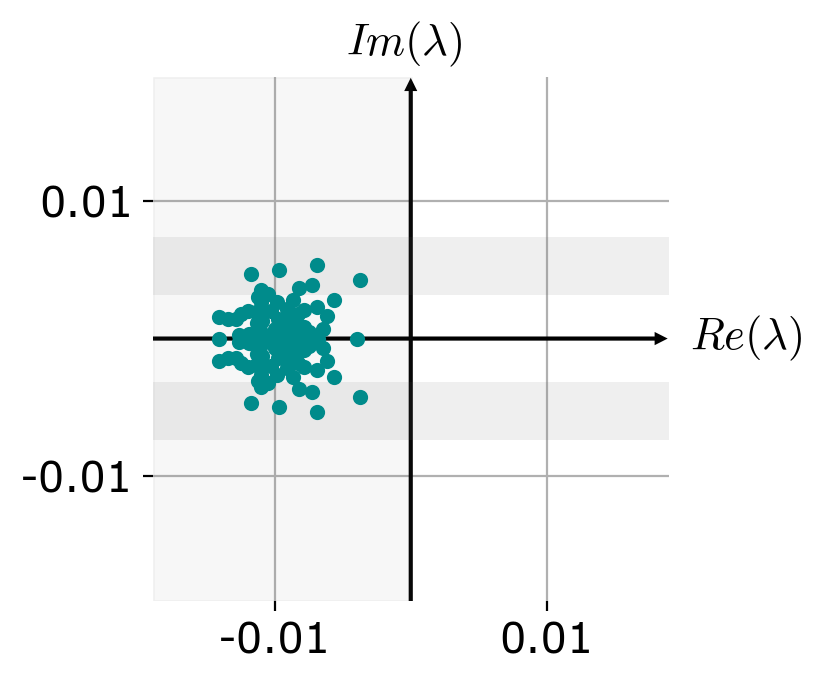

In [50]:
# Plot eigenvalues of Jacobian 

w = 0.019
fig, ax = plt.subplots(figsize=(4.3, 3.6), dpi=200)

plt.axis('on')
plt.grid()
plt.text(-0.25 * w, 1.08 * w, r'$Im(\lambda)$', fontsize=16)
plt.text(1.08 * w,  -0.04 * w, r'$Re(\lambda)$', fontsize=16)
plt.xlim(-w, w)
plt.ylim(-w, w)
plt.arrow(0, -w, 0, 1.95 * w, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
plt.arrow(-w, 0, 1.95 * w, 0, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)

for i in range(len(eigvals)):
    x = eigvals_jacobian[i].real
    y = eigvals_jacobian[i].imag
    plt.scatter(x, y, color='darkcyan', s=20, zorder=3)

circle = plt.Circle((0,0), 1, color='k', alpha=0.2, fill=False)
plt.gcf().gca().add_artist(circle)

ax.axvspan(-w, 0, alpha=0.05, color='dimgrey')
ax.axhspan(hz_to_eigval(15), hz_to_eigval(35), alpha=0.1, color='dimgrey', ec=None) # beta frequency range
ax.axhspan(hz_to_eigval(-15), hz_to_eigval(-35), alpha=0.1, color='dimgrey', ec=None)

ax.set_xticks([-0.01, 0.01])
ax.set_xticklabels([-0.01, 0.01])
ax.set_yticks([-0.01, 0.01])
ax.set_yticklabels([-0.01, 0.01])

sns.despine(top=True, right=True, left=True, bottom=True)
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig('positive_sigmoid_delay/eigenvalues_jacobian.png', dpi=230)
plt.show()

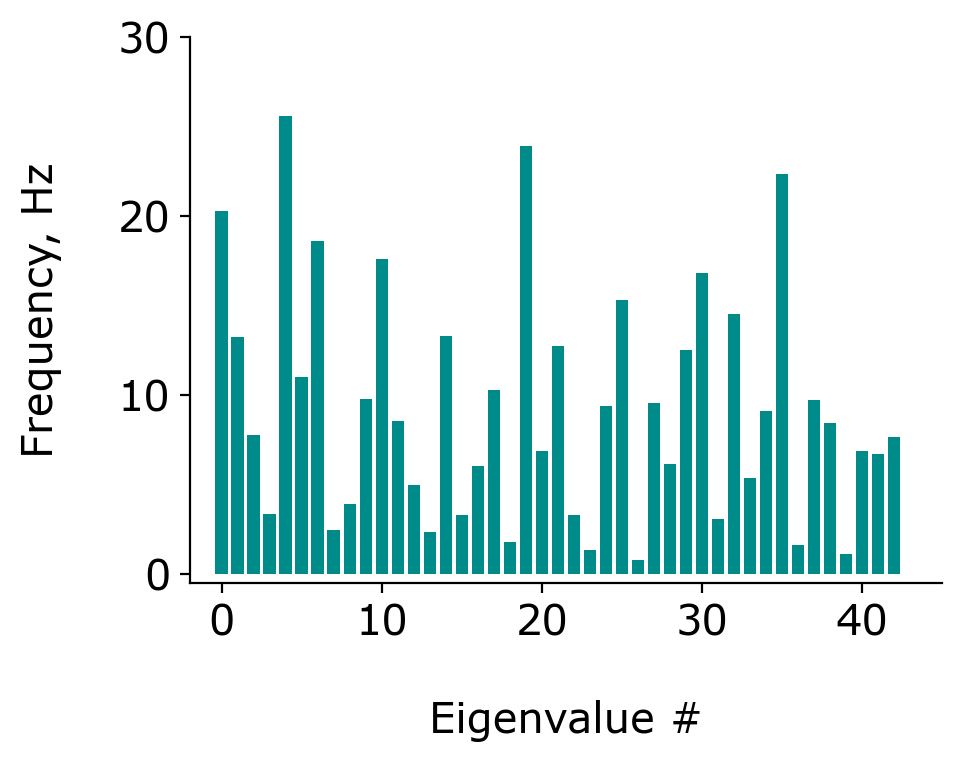

In [51]:
# Plot frequencies of each eigenvalue 

frequencies = [eigval_to_hz(x) for x in eigvals_jacobian.imag]

freq_unique = np.delete(np.array(frequencies), np.array(frequencies)<=0)
eigvals_real_unique = eigvals_jacobian.real[::2]

fig, ax = plt.subplots(figsize=(5, 4), dpi=200)
ax.bar(range(len(freq_unique)), freq_unique, color=main_color)
ax.add_patch(patches.Rectangle((-1, -0.5), 100, 0.5, facecolor='white', fill=True))
ax.set_xlabel('Eigenvalue #', labelpad=20)
ax.set_ylim(-.5, 30)
ax.set_ylabel('Frequency, Hz', labelpad=20)
ax.set_xlim(-2, 45)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()
plt.savefig('positive_sigmoid_delay/frequencies.png', dpi=200)
plt.show()


### Matrix histogram

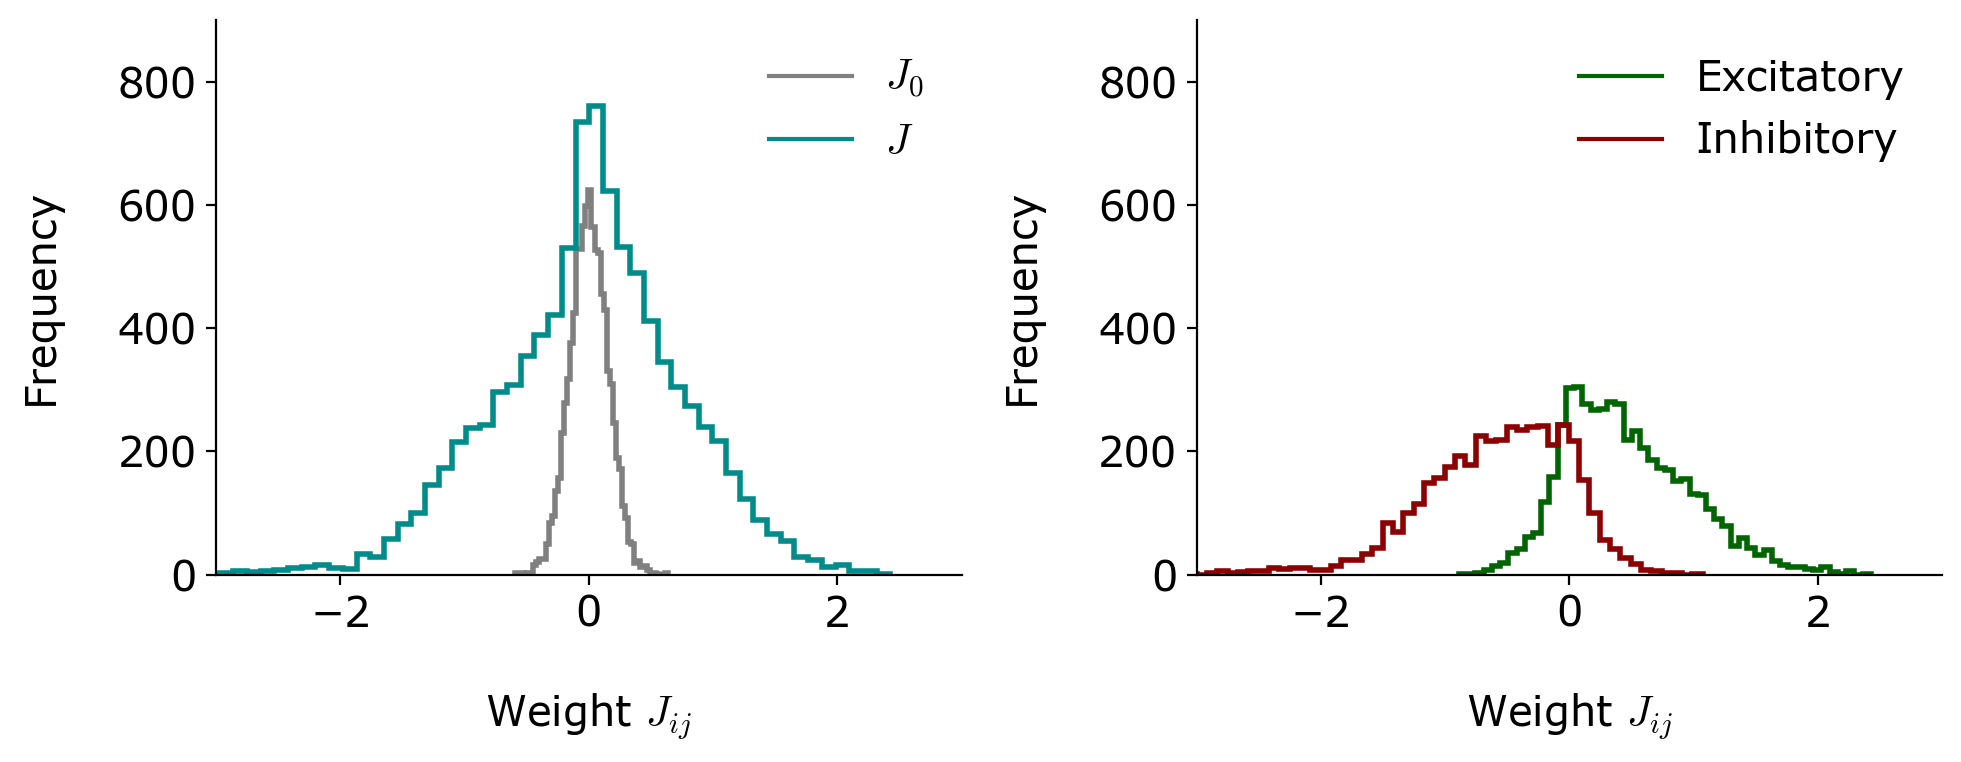

In [52]:
# Histogram of matrix values before and after training

pos_idx = np.mean(J, axis=0)>=0
neg_idx = np.mean(J, axis=0)<0

J_exc = J[:, pos_idx] # matrix columns in which mean is positive
J_inh = J[:, neg_idx] # matrix columns in which mean is negative

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

ax1.hist(J0.flatten(), histtype='step', bins=50, lw=2, color='grey', alpha=1,)
ax1.hist(J.flatten(), histtype='step', bins=50, lw=2, color='darkcyan')
ax1.plot(0, 0, color='grey', label=r'$J_0$')
ax1.plot(0, 0, color='darkcyan', label=r'$J$')

ax2.hist(J_exc.flatten(), histtype='step', bins=50, lw=2, color=positive_color)
ax2.hist(J_inh.flatten(), histtype='step', bins=50, lw=2, color=negative_color)
ax2.plot(0, 0, color=positive_color, label='Excitatory')
ax2.plot(0, 0, color=negative_color, label='Inhibitory')

for ax in (ax1, ax2):
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 900)
    ax.set_ylabel('Frequency')
    ax.set_xlabel(r'Weight $J_{ij}$', labelpad=20)
    ax.legend(frameon=False, loc=0, fontsize=15)
    sns.despine(ax=ax, top=True, right=True)

plt.tight_layout()
plt.savefig('positive_sigmoid_delay/matrix_histogram.png', dpi=200)
plt.show()


### PCA

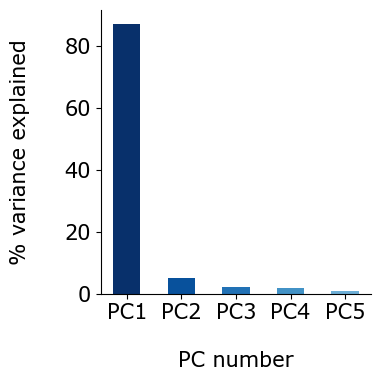

In [53]:
# Eigenvalues and eigenvectors

covmat = zs_all[-1].dot(zs_all[-1].T)
eigvals, eigvecs = np.linalg.eigh(covmat)
eigvals = eigvals[::-1]
eigvecs = eigvecs[:, ::-1]

# Percentage variance explained by each eigenvalue
var_exp_readouts = [(i / np.sum(eigvals)) * 100 for i in eigvals]  

fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
colors = pl.cm.Blues_r(np.linspace(0, 0.5, 5))
ax.bar((0, 1, 2, 3, 4), (var_exp_readouts[0], var_exp_readouts[1], var_exp_readouts[2], var_exp_readouts[3], var_exp_readouts[4]), color=colors, width=0.5)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
ax.set_xlabel("PC number", labelpad=20)
ax.set_ylabel("% variance explained", labelpad=25)

sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout()
plt.show()

In [54]:
# Projection of readouts onto first PCs

%matplotlib notebook 
%matplotlib notebook 

# Projections 
projs = np.dot(zs_all[-1].T, eigvecs[:, 0:3])
projs_fp = np.dot(fixed_point.T, eigvecs[:, 0:3])
projs_noise = np.dot(zs_noise.T, eigvecs[:, 0:3])
projs_eigvec1 = np.dot(eigvecs_jacobian[0].real.T, eigvecs[:, 0:3])
projs_eigvec2 = np.dot(eigvecs_jacobian[1].real.T, eigvecs[:, 0:3])
projs_targets1 = np.dot(targets[0].T, eigvecs[:n_targets, 0:3])

# Eigenvector direction lines
length_line = 10
start_point_eigvec1 = projs_fp - (projs_eigvec1.real) * length_line
start_point_eigvec2 = projs_fp - (projs_eigvec2.real) * length_line
end_point_eigvec1 = projs_fp + (projs_eigvec1.real) * length_line
end_point_eigvec2 = projs_fp + (projs_eigvec2.real) * length_line
eigvec1_line = np.vstack((start_point_eigvec1, end_point_eigvec1))
eigvec2_line = np.vstack((start_point_eigvec2, end_point_eigvec2))

max_val = np.max(projs[:, 0]) - 0

fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=100)
ax = plt.axes(projection='3d')
ax.grid(False)
ax.plot(projs_targets1[:, 0], projs_targets1[:, 1], projs_targets1[:, 2], lw=2, color='grey', alpha=0.3)
ax.plot(projs[:, 0], projs[:, 1], projs[:, 2], lw=2, color='darkcyan', alpha=0.6)
# ax.plot(projs_noise[:, 0], projs_noise[:, 1], projs_noise[:, 2], lw=2, color='steelblue', alpha=0.4)
ax.plot(eigvec1_line[:, 0], eigvec1_line[:, 1], eigvec1_line[:, 2], color='firebrick')
ax.plot(eigvec2_line[:, 0], eigvec2_line[:, 1], eigvec2_line[:, 2], color='firebrick')
ax.plot(projs_fp[0], projs_fp[1], projs_fp[2], marker='o', markersize=6, color='firebrick')
ax.set_xlim(-max_val, max_val)
ax.set_ylim(-max_val, max_val)
ax.set_zlim(-max_val, max_val)

ax.w_xaxis.set_pane_color((0.98, 0.98, 0.98, 0.98))
plt.tight_layout()
plt.savefig('positive_sigmoid_delay/PCA.png', dpi=200)
plt.show()

<IPython.core.display.Javascript object>

In [55]:
%matplotlib inline

### Weight decay analysis

In [21]:
# Calculate mean weight per distance 

distances = np.arange(0, 10, 1)

tau_trial = ms_to_tau(200)
amp_trial = 0.05
tau_baseline = ms_to_tau(33)
amp_baseline = 0.00
n_train = 10
dt_weight_update = 10
D = 0

dist_means_J_all = []
dist_stds_J_all = []
dist_means_J0_all = []
dist_stds_J0_all = []
pos_means_J_all = []
pos_stds_J_all = []
neg_means_J_all = []
neg_stds_J_all = []

for repeat in range(10):
    
    J0, J = training(D, dt_weight_update, n_train, tau_trial, tau_baseline, amp_trial, amp_baseline)
    dist_means_J, dist_stds_J = weights_vs_distance(J, distances)
    dist_means_J0, dist_stds_J0 = weights_vs_distance(J0, distances)
    pos_means_J, pos_stds_J, neg_means_J, neg_stds_J = weights_vs_distance_pos_neg(J, distances)
    
    dist_means_J_all.append(dist_means_J)
    dist_stds_J_all.append(dist_stds_J)
    dist_means_J0_all.append(dist_means_J0)
    dist_stds_J0_all.append(dist_stds_J0)
    
    pos_means_J_all.append(pos_means_J)
    pos_stds_J_all.append(pos_stds_J)
    neg_means_J_all.append(neg_means_J)
    neg_stds_J_all.append(neg_stds_J)
    
dist_means_J_avg = np.mean(dist_means_J_all, axis=0)
dist_stds_J_avg = np.mean(dist_stds_J_all, axis=0)
dist_means_J0_avg = np.mean(dist_means_J0_all, axis=0)
dist_stds_J0_avg = np.mean(dist_stds_J0_all, axis=0)
pos_means_J_avg = np.mean(pos_means_J_all, axis=0)
pos_stds_J_avg = np.mean(pos_stds_J_all, axis=0)
neg_means_J_avg = np.mean(neg_means_J_all, axis=0)
neg_stds_J_avg = np.mean(neg_stds_J_all, axis=0)

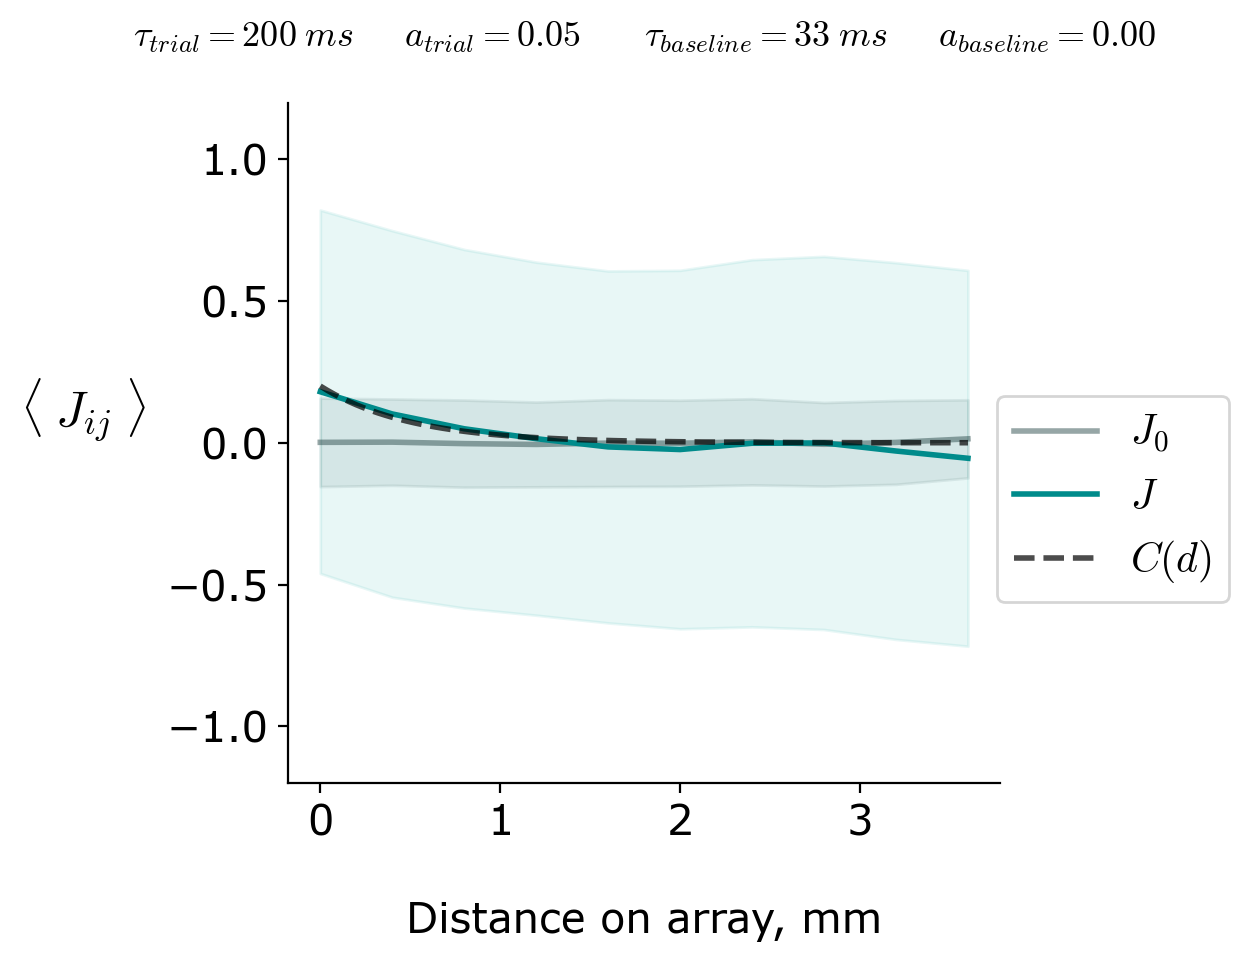

In [36]:
# Mean weight decay across all weights

fig, ax = plt.subplots(figsize=(6.2, 5), dpi=200)

def weight_function(distances, a, lambd):
    return [a * np.exp(-lambd * dist) for dist in distances]

distances = np.arange(0, 10, 1) * 0.4
dists_finescale = np.arange(0, 9.1, 0.1) * 0.4

ax.plot(distances, dist_means_J0_avg, color=main_color_dark, lw=2, alpha=.5, label=r'$J_0$')
ax.plot(distances, dist_means_J_avg, color=main_color, lw=2, label=r'$J$')
ax.plot(dists_finescale, weight_function(dists_finescale, 0.2, 2), color='k', alpha=0.7, ls='--', lw=2, label=r'$C(d)$')

plt.fill_between(distances, np.array(dist_means_J0_avg)-dist_stds_J0_avg, np.array(dist_means_J0_avg)+dist_stds_J0_avg, alpha=.1, color=main_color_dark)
plt.fill_between(distances, np.array(dist_means_J_avg)-dist_stds_J_avg, np.array(dist_means_J_avg)+dist_stds_J_avg, alpha=.1, color='lightseagreen')

ax.set_xlabel('Distance on array, mm')
ax.set_ylabel(r'$\langle \; J_{ij} \; \rangle$', fontsize=18, labelpad=30, rotation=0)
ax.set_title(r'$\tau_{trial} = %.f \; ms$    $a_{trial}=%.2f$     $\tau_{baseline} = %.f \; ms$    $a_{baseline}=%.2f$' % (tau_to_ms(tau_trial), amp_trial, tau_to_ms(tau_baseline), amp_baseline), pad=20, fontsize=13)

ax.set_ylim(-1.2, 1.2)
ax.legend(loc=1, bbox_to_anchor=[1.35, 0.6], fontsize=15)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()
plt.show()

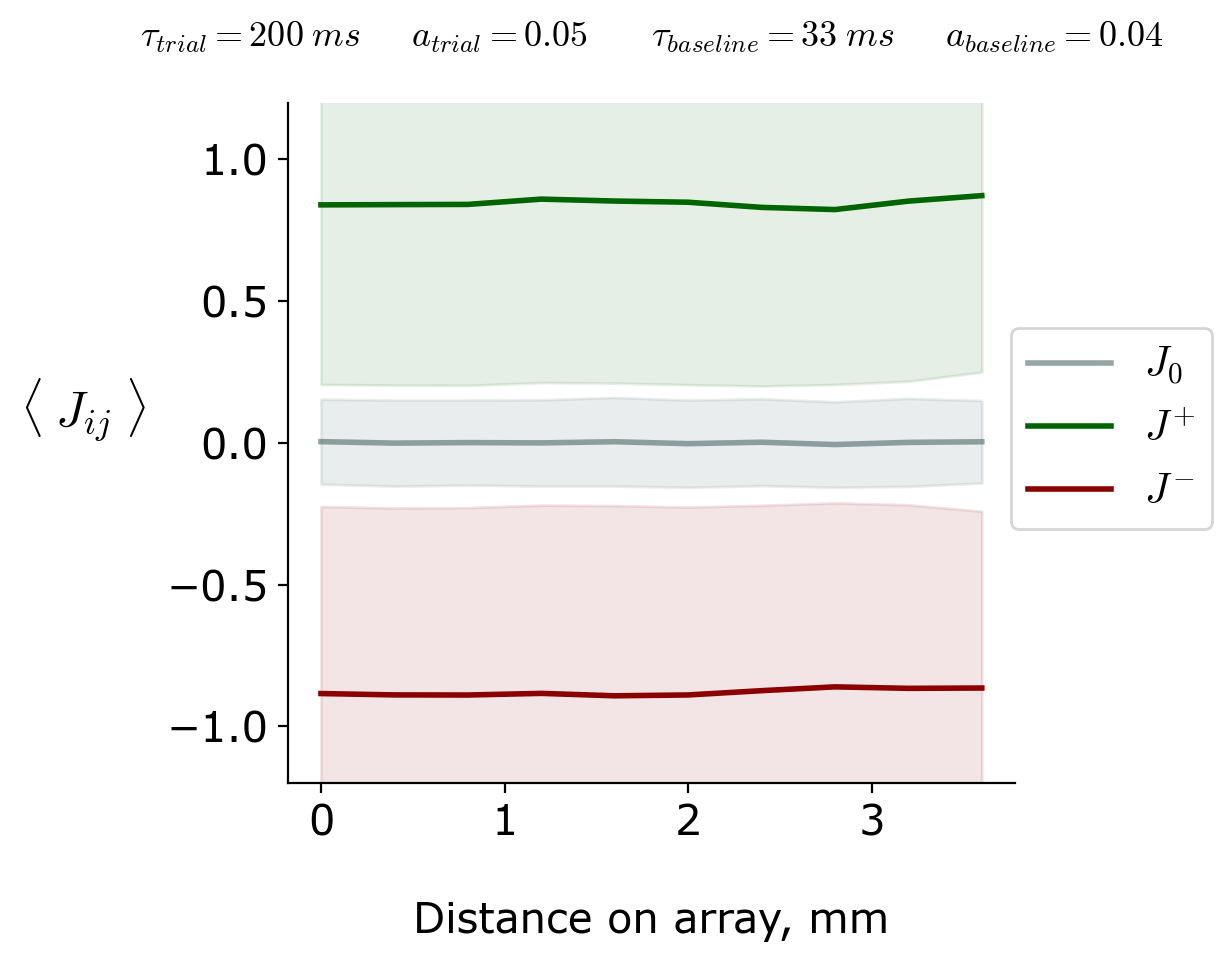

In [174]:
# Mean weight decay for positive and negative weights

fig, ax = plt.subplots(figsize=(6.2, 5), dpi=200)

distances = np.arange(0, 10, 1) * 0.4

ax.plot(distances, dist_means_J0_avg, color=main_color_dark, lw=2, alpha=.5, label=r'$J_0$')
ax.plot(distances, pos_means_J_avg, color=positive_color, lw=2, label=r'$J^{+}$')
ax.plot(distances, neg_means_J_avg, color=negative_color, lw=2, label=r'$J^{-}$')

plt.fill_between(distances, np.array(dist_means_J0_avg)-dist_stds_J0_avg, np.array(dist_means_J0_avg)+dist_stds_J0_avg, alpha=.1, color=main_color_dark)
plt.fill_between(distances, np.array(pos_means_J_avg)-pos_stds_J_avg, np.array(pos_means_J_avg)+pos_stds_J_avg, alpha=.1, color=positive_color)
plt.fill_between(distances, np.array(neg_means_J_avg)-neg_stds_J_avg, np.array(neg_means_J_avg)+neg_stds_J_avg, alpha=.1, color=negative_color)

ax.set_xlabel('Distance on array, mm')
ax.set_ylabel(r'$\langle \; J_{ij} \; \rangle$', fontsize=18, labelpad=30, rotation=0)
ax.set_title(r'$\tau_{trial} = %.f \; ms$    $a_{trial}=%.2f$     $\tau_{baseline} = %.f \; ms$    $a_{baseline}=%.2f$' % (tau_to_ms(tau_trial), amp_trial, tau_to_ms(tau_baseline), amp_baseline), pad=20, fontsize=13)

ax.set_ylim(-1.2, 1.2)
ax.legend(loc=1, bbox_to_anchor=[1.3, 0.7], fontsize=15)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()
plt.show()

### Training across noise timescales

In [194]:
# Network parameters

def training_error(n_neurons, tau_trial, amp_trial, tau_baseline, amp_baseline, mean):
    """
    Train network with given input noise parameters; return mean squared error after training 
    """
    N = n_neurons
    n_targets = len(targets[0]) 

    g = 1.5
    tau = 100 
    D = 0
    dt_weight_update = 10
    alpha = 1 

    T = max_length
    dt = 1 
    iterations = int(T/dt)  
    times = np.linspace(0, T, iterations)

    n_train = 10
    n_free = 1
    n_tot = n_train + n_free 

    noise_trial = get_noise(N, 1, tau_trial, amp_trial, mean)
    noise_baseline = get_noise(N, 1, tau_baseline, amp_baseline, mean) 

    P = np.eye(n_targets) / alpha 
    J0 = np.random.randn(N, N) * g / np.sqrt(N) 
    J = J0.copy()

    mses = []

    for run in range(n_tot):

        xs = np.zeros((N, iterations))  
        zs = np.zeros((N, iterations)) 
        mse = []

        if run>0:
            xs[:, 0] = last_run

        for t in range(D, iterations-1):

            xs[:, t+1] = xs[:, t] + (-xs[:, t] + J.dot(nonlinearity(xs[:, t-D])) + noise_trial[0][:, t] + noise_baseline[0][:, t]) * dt / tau
            r = nonlinearity(xs[:, t+1]) 
            r = r[:, None]    
            zs[:, t+1] = J.dot(np.squeeze(r))

            if run < n_train and t % dt_weight_update == 0:

                errs = zs[:n_targets, t+1] - targets[0][:, t+1]
                mse.append(np.mean(errs**2))

                k = P.dot(r[:n_targets])
                rPr = r[:n_targets].T.dot(k)
                c = 1.0 / (1.0 + rPr)
                P = P - c * (k.dot(k.T))

                delta_w = - (c * np.outer(errs, k))
                J[:n_targets, :n_targets] += delta_w
                J[np.isclose(J, 0.0, atol=1e-04)] = 0.0

        last_run = xs[:, -1]

        mses.append(np.mean(mse))

    return mses[-2]


In [248]:
amp_trial = 0.05
amp_baseline = 0.00
amps = np.logspace(-2, 0, num=10, endpoint=True)

repeats = 5

errors_mean_trial = []
errors_std_trial = []

for amp in amps:
    
    errors = []
    for repeat in range(repeats):
        errors.append(training_error(N, ms_to_tau(200), amp, ms_to_tau(50), amp_baseline, 0.0))

    errors_mean_trial.append(np.mean(errors))
    errors_std_trial.append(np.std(errors))
    
    print(amp)


/opt/anaconda3/envs/multielectrode_grasp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/multielectrode_grasp/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.01
0.016681005372000592
0.027825594022071243
0.046415888336127774
0.0774263682681127
0.1291549665014884
0.21544346900318834
0.3593813663804626
0.5994842503189409
1.0


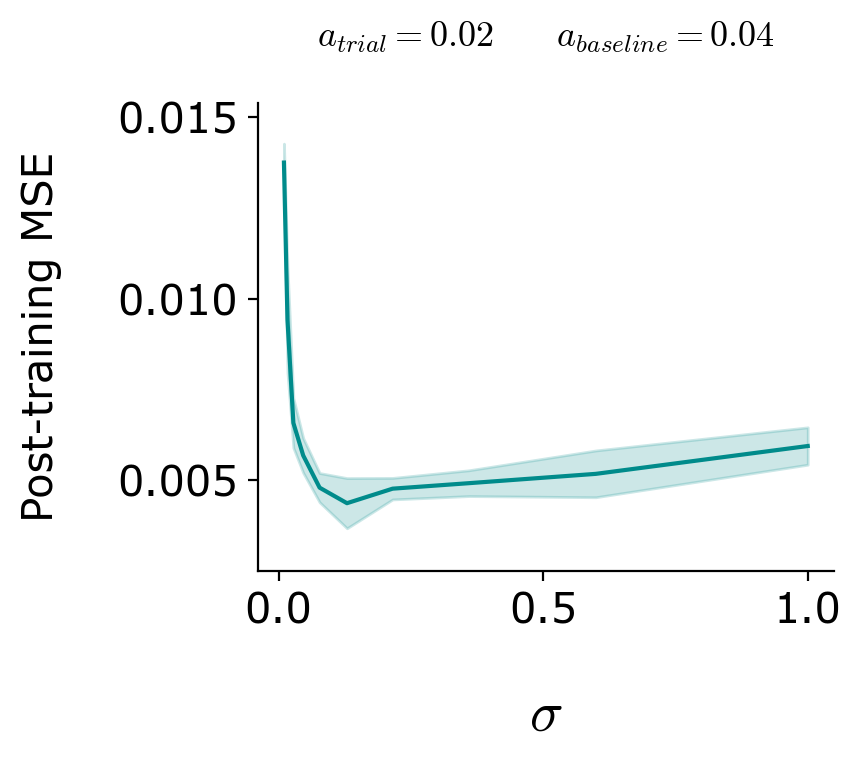

In [267]:
fig, ax = plt.subplots(figsize=(4.5, 4), dpi=200)

taus_rescale = tau_to_ms(tau_trial)

color_g = 'darkcyan'

ax.plot(amps, errors_mean_trial, color=color_g)

sns.despine(ax=ax, top=True, right=True)

plt.fill_between(amps, np.array(errors_mean_trial)-errors_std_trial, np.array(errors_mean_trial)+errors_std_trial, alpha=.2, color=color_g)

ax.set_xlabel(r'$\sigma$', fontsize=20)
ax.set_ylabel('Post-training MSE')
ax.set_ylim(0.0025, 0.0154)
# ax.set_xscale('log')
ax.set_title(r'$a_{trial}=%s$     $a_{baseline}=%s$' % (0.02, 0.04), pad=20, fontsize=13)

fig.tight_layout()
plt.show()
